# Calculate marginal ice zone widths and areas from ACCESS-OM3

This notebook demonstrates how to calculate the marginal ice zone (MIZ) width and area from ACCESS-OM3 MOM–CICE–WW3 outputs.

MIZ defintions:
- Significant wave heights ($H_s$)
- Ice concentration ($a_\text{ice}$)
- Floe size ($r_a$)


**TO-DO**:
- Make download path the user's default project
- Need to check if the directory exists already

In [1]:
### USER EDIT start
# esm_file = "/g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json"
esm_file = "/scratch/ps29/nd0349/access-om3/archive/IC4M8-MCW-100km_jra_ryf/experiment_datastore.json"
dpi=300
### USER EDIT stop

import os
from matplotlib import rcParams
%matplotlib inline
rcParams["figure.dpi"]= dpi

plotfolder=f"/g/data/{os.environ['PROJECT']}/{os.environ['USER']}/access-om3-paper-figs/"
os.makedirs(plotfolder, exist_ok=True)

 # a similar cell under this means it's being run in batch
print("ESM datastore path: ",esm_file)
print("Plot folder path: ",plotfolder)

ESM datastore path:  /scratch/ps29/nd0349/access-om3/archive/IC4M8-MCW-100km_jra_ryf/experiment_datastore.json
Plot folder path:  /g/data/ps29/nd0349/access-om3-paper-figs/


In [2]:
import xarray as xr
import cf_xarray
import intake
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from distributed import Client
import cmocean.cm as cmo

import matplotlib.path as mpath
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, BoundaryNorm

import cartopy.feature as cft
import cftime

import geopandas as gpd

from matplotlib.colors import ListedColormap, BoundaryNorm

import os
import requests
import zipfile

In [3]:
client = Client(threads_per_worker=1)
client
# print(client.dashboard_link)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36777 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/36777/status,
Dashboard: /proxy/36777/status,Workers: 14
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34541,Workers: 0
Dashboard: /proxy/36777/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:37707,Total threads: 1
Dashboard: /proxy/41663/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:37033,


2025-12-08 17:50:33,276 - distributed.nanny - WARNING - Restarting worker
2025-12-08 17:50:33,278 - distributed.nanny - WARNING - Restarting worker
2025-12-08 17:50:33,281 - distributed.nanny - WARNING - Restarting worker
2025-12-08 17:50:33,285 - distributed.nanny - WARNING - Restarting worker
2025-12-08 17:50:33,290 - distributed.nanny - WARNING - Restarting worker
2025-12-08 17:50:33,294 - distributed.nanny - WARNING - Restarting worker
2025-12-08 17:50:33,298 - distributed.nanny - WARNING - Restarting worker
2025-12-08 17:50:33,303 - distributed.nanny - WARNING - Restarting worker
2025-12-08 17:50:33,307 - distributed.nanny - WARNING - Restarting worker
2025-12-08 17:50:34,175 - distributed.nanny - WARNING - Restarting worker
2025-12-08 17:50:35,976 - distributed.nanny - WARNING - Restarting worker
2025-12-08 17:50:35,986 - distributed.nanny - WARNING - Restarting worker
2025-12-08 17:50:36,011 - distributed.nanny - WARNING - Restarting worker
2025-12-08 17:50:37,415 - distributed.

### Open the intake-esm datastore

In [4]:
COLUMNS_WITH_ITERABLES = [
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
]

datastore = intake.open_esm_datastore(
    esm_file,
    columns_with_iterables=COLUMNS_WITH_ITERABLES
)


### What ocean variables are available at monthly frequency?

In [5]:
def available_variables(datastore):
    """Return a pandas dataframe summarising the variables in a datastore"""
    variable_columns = [col for col in datastore.df.columns if "variable" in col]
    return (
        datastore.df[variable_columns]
        .explode(variable_columns)
        .drop_duplicates()
        .set_index("variable")
        .sort_index()
    )

In [6]:
datastore_filtered = datastore.search(realm="seaIce", frequency="1mon")

available_variables(datastore_filtered)

,variable_long_name,variable_standard_name,variable_cell_methods,variable_units
variable,,,,
ANGLE,angle grid makes with latitude line on U grid,,,radians
ANGLET,angle grid makes with latitude line on T grid,,,radians
NCAT,category maximum thickness,,,m
Tair_m,air temperature,,time: mean,C
Tsfc_m,snow/ice surface temperature,,time: mean,C
...,...,...,...,...
vatm_m,atm velocity (y),,time: mean,m/s
vicen_m,"ice volume, categories",,time: mean,m
vort_m,strain rate (vorticity),,time: mean,%/day


### Load ice concentration, signficant wave height, and floe size

In [7]:
ds = datastore.search(variable=["aice_m", "wave_sig_ht_m", "fsdrad_m"], frequency="1mon").to_dask(
    xarray_combine_by_coords_kwargs = dict( # These kwargs can make things faster
        compat="override",
        data_vars="minimal",
        coords="minimal",
    ),
    xarray_open_kwargs = dict(
        chunks={"nj": -1, "ni": -1}, # Good for spatial operations, but not temporal
        decode_timedelta=True
    )
)
ds_grid = datastore.search(variable=["tarea", "HTE"], frequency="fx", realm="seaIce").to_dask().compute()
ds_grid

coords = datastore.search(variable=["geolat", "geolon"], file_id='access_om3_mom6_static'
                         ).to_dask().compute() # TODO why do we need file_id for my runs??
coords = coords.fillna(0.0)
coords = coords.rename({'geolat': 'lat', 'geolon': 'lon'})

ds = xr.merge([ds, ds_grid])
ds = ds.rename({'nj': 'yh',
                'ni': 'xh'}
)

ds = ds.assign_coords(coords)
ds

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/source.py:308: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/source.py:308: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(


<xarray.Dataset> Size: 83MB
Dimensions:        (time: 28, yh: 300, xh: 360)
Coordinates: (12/13)
  * time           (time) object 224B 1900-01-16 12:00:00 ... 1902-04-16 00:0...
    TLON           (yh, xh) float64 864kB nan nan nan nan ... nan nan nan nan
    TLAT           (yh, xh) float64 864kB nan nan nan nan ... nan nan nan nan
    ULON           (yh, xh) float64 864kB nan nan nan nan ... nan nan nan nan
    ULAT           (yh, xh) float64 864kB nan nan nan nan ... nan nan nan nan
    NLON           (yh, xh) float64 864kB nan nan nan nan ... nan nan nan nan
    ...             ...
    ELON           (yh, xh) float64 864kB nan nan nan nan ... nan nan nan nan
    ELAT           (yh, xh) float64 864kB nan nan nan nan ... nan nan nan nan
  * xh             (xh) float64 3kB -279.5 -278.5 -277.5 ... 77.5 78.5 79.5
  * yh             (yh) float64 2kB -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
    lon            (yh, xh) float64 864kB 0.0 0.0 0.0 0.0 ... 79.96 79.97 79.99
    lat            (yh, xh) float64 864kB 0.0 0.0 0.0 0.0 ... 66.04 65.63 65.21
Data variables:
    aice_m         (time, yh, xh) float64 24MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    wave_sig_ht_m  (time, yh, xh) float64 24MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    fsdrad_m       (time, yh, xh) float64 24MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    tarea          (yh, xh) float64 864kB nan nan nan nan ... nan nan nan nan
    HTE            (yh, xh) float64 864kB nan nan nan nan ... nan nan nan nan
Attributes: (12/21)
    title:                                    access-om3
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   CICE Sea Ice Model, unknown_ver...
    comment:                                  All years have exactly 365 days
    comment3:                                 seconds elapsed into model date...
    time_period_freq:                         month_1
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,,time: mean,time: mean,...
    intake_esm_attrs:variable_units:          days since 1900-01-01 00:00:00,...
    intake_esm_attrs:realm:                   seaIce
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_cice_1mon_mean_XXXX_...

## Compare a particular day against NSIDC marginal ice zone observations

- https://noaadata.apps.nsidc.org/NOAA/G10017/

First, let's get a model time to compare against.

In [8]:
t0 = ds.time[3].values.item()  
t_str = t0.strftime("%Y-%m-%d")
day = t0.strftime("%d")
month = t0.strftime("%m")
if t0.strftime("%Y")[0:3] == '190':
    # RYF RUN
    year = '1990'
else:
    year = t0.strftime("%Y")
day_of_year = (t0 - cftime.DatetimeNoLeap(t0.year, 1, 1)).days + 1

In [24]:
def get_ice_charts_data(base_path, folder_name, year):
    url = f"https://noaadata.apps.nsidc.org/NOAA/G10017/south/{year}/{folder_name}.zip"
            
    # File paths
    # raw_file = base_path + folder_name
    zip_file = os.path.join(base_path, year, folder_name + ".zip")
    extract_dir = os.path.join(base_path, year, folder_name)

    # If extracted directory already exists, do nothing
    if os.path.isdir(extract_dir):
        print(f"{extract_dir} already exists — skipping download & extraction.")
        return

    # # Download the file if missing
    # if not os.path.exists(extract_dir):
    #     print(f"{raw_file} not found. Downloading…")
    #     r = requests.get(url, stream=True)
    #     r.raise_for_status()
        
    #     with open(raw_file, "wb") as f:
    #         for chunk in r.iter_content(8192):
    #             f.write(chunk)
    #     os.rename(extract_dir, raw_file)
    #     # print("Download complete.")
    # else:
    #     print("Raw file already — skipping download.")

    # Download the file if missing
    # Check if URL exists
    try:
        head = requests.head(url)
        if head.status_code != 200:
            print(f"URL does not exist ({url}) — skipping download.")
            return
    except requests.RequestException as e:
        print(f"Error checking URL: {e} — skipping download.")
        return
        
    if not os.path.exists(zip_file):
        print(f"{zip_file} not found. Downloading…")
        r = requests.get(url, stream=True)
        r.raise_for_status()
        with open(zip_file, "wb") as f:   # download directly to ZIP file
            for chunk in r.iter_content(8192):
                f.write(chunk)
        # print("Download complete.")
    else:
        print("ZIP file already exists — skipping download.")
        
    
    # if os.path.exists(raw_file):
    #     # os.rename(raw_file, zip_file)
    #     # print(f"Renamed {raw_file} → {zip_file}")
    # else:
    #     print("Zip file already exists — skipping rename.")

    if os.path.exists(zip_file):
        if not zipfile.is_zipfile(zip_file):
            print("WARNING: File is not a ZIP archive.")
            raise ValueError("USNIC file is not a valid ZIP.")
    
    if not os.path.exists(extract_dir):
        print(f"Extracting into {extract_dir}…")
        os.makedirs(extract_dir)
        with zipfile.ZipFile(zip_file, "r") as z:
            z.extractall(extract_dir)
        # print("Extraction complete.")

         # Delete the zip file
        try:
            os.remove(zip_file)
            print(f"Deleted ZIP file: {zip_file}")
        except Exception as e:
            print(f"WARNING: Could not delete ZIP file: {e}")
    else:
        print(f"{extract_dir} already exists — skipping extraction.")
    return 

year='2010'
folder_name = f"nic_miz{year}{day_of_year:03d}sc_pl_a"
base_path = "/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/"

get_ice_charts_data(base_path, folder_name, year)

/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2010/nic_miz2010121sc_pl_a.zip not found. Downloading…
Extracting into /g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2010/nic_miz2010121sc_pl_a…
Deleted ZIP file: /g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2010/nic_miz2010121sc_pl_a.zip


In [10]:
folder_name

'nic_miz2010106sc_pl_a'

In [11]:
def get_proj(hemisphere):
    if hemisphere.lower().startswith('s'):
        projection = ccrs.SouthPolarStereo(central_longitude=0)
        extent = [-180, 180, -90, -40]
    elif hemisphere.lower().startswith('n'):
        projection = ccrs.Stereographic(
            central_latitude=90.0,
            central_longitude=-45.0,
            true_scale_latitude=60.0,
            globe=ccrs.Globe(semimajor_axis=6378273.0, semiminor_axis=6356889.448910593)
        )
        extent = [0, 360, 40, 90]
    else:
        raise ValueError("hemisphere must be 'north' or 'south'")
    return projection, extent

# def make_fig(number_panels=1, hemisphere='south'):
   
#     projection, extent = get_proj(hemisphere)
    
#     fig, axes = plt.subplots(
#         ncols=number_panels,
#         subplot_kw={'projection': projection},
#         figsize=(4 * number_panels, 4),
#         gridspec_kw={'wspace': 0.25, 'hspace': 0.15}
#     )

    
#     for ax in axes:
#         ax.set_extent(extent, crs=ccrs.PlateCarree())
#        # Add land texture:
#         # ax.imshow(
#         #     blue_marble, extent=blue_marble_extent, transform=ccrs.PlateCarree(), origin="upper"
#         # )
#         # Make a circle plot
#         theta = np.linspace(0, 2*np.pi, 100)
#         center, radius = [0.5, 0.5], 0.5
#         verts = np.vstack([np.sin(theta), np.cos(theta)]).T
#         circle = mpath.Path(verts * radius + center)
#         ax.set_boundary(circle, transform=ax.transAxes)
#         ax.set_title("NO DATA")

#     return fig, axes

# def plot(dat,  dat_ice=None, ax=None, title=None, hemisphere='south', label="", vmin=None, vmax=None, **kwargs):
#     if title is None:
#     #     # title = dat.attrs['long_name']
#         title = "NO DATA"
        
#     if ax == None:
#         fig, ax = make_fig(hemisphere='south')
    
#     dat.plot.contourf(
#         ax=ax,
#         x="lon", 
#         y="lat", 
#         vmin=vmin,
#         vmax=vmax,
#         transform=ccrs.PlateCarree(),
#         cbar_kwargs={"label": label, # "\n".join(wrap(f"{dat.attrs['long_name']} [{dat.attrs['units']}]", 45))
#                      "fraction": 0.03, "aspect": 15, "shrink": 0.7},
#         **kwargs
#     )
#     ax.set_title(title);
#     if dat_ice is not None:
#         add_ice_contours(ax, dat_ice, hemisphere)

# def add_ice_contours(ax, dat_ice, hemisphere):

#     projection, extent = get_proj(hemisphere)
        
#     transformed_coor=projection.transform_points(ccrs.PlateCarree(),dat_ice['lon'].values,dat_ice['lat'].values)
#     x_ster,y_ster=transformed_coor[:,:,0],transformed_coor[:,:,1]
#     use_transformed_coordinates_directly = True
    
#     if use_transformed_coordinates_directly:
#         cs = ax.contour(x_ster,y_ster,dat_ice['aice_m'],levels=[1e-12, 0.15, 0.8],linestyles=[":", "-", "--"],colors="magenta",linewidths=0.5)
#     else:
#         cs = ax.contour(dat_ice['lon'],dat_ice['lat'],dat_ice['aice_m'],levels=[1e-12, 0.15, 0.8],transform=ccrs.PlateCarree(),
#                     linestyles=[":", "-", "--"],colors="magenta",linewidths=0.5)
                
#     return cs

In [12]:
# miz = (ds.sel(time=t)['aice_m'] > 0.1) & (ds.sel(time=t)['aice_m'] < 0.8)
# miz.plot()

Calculate the USNIC defintion of the marginal ice zone being between 0.1 and 0.8 

Text(0.5, 1.0, '1900-04-16')

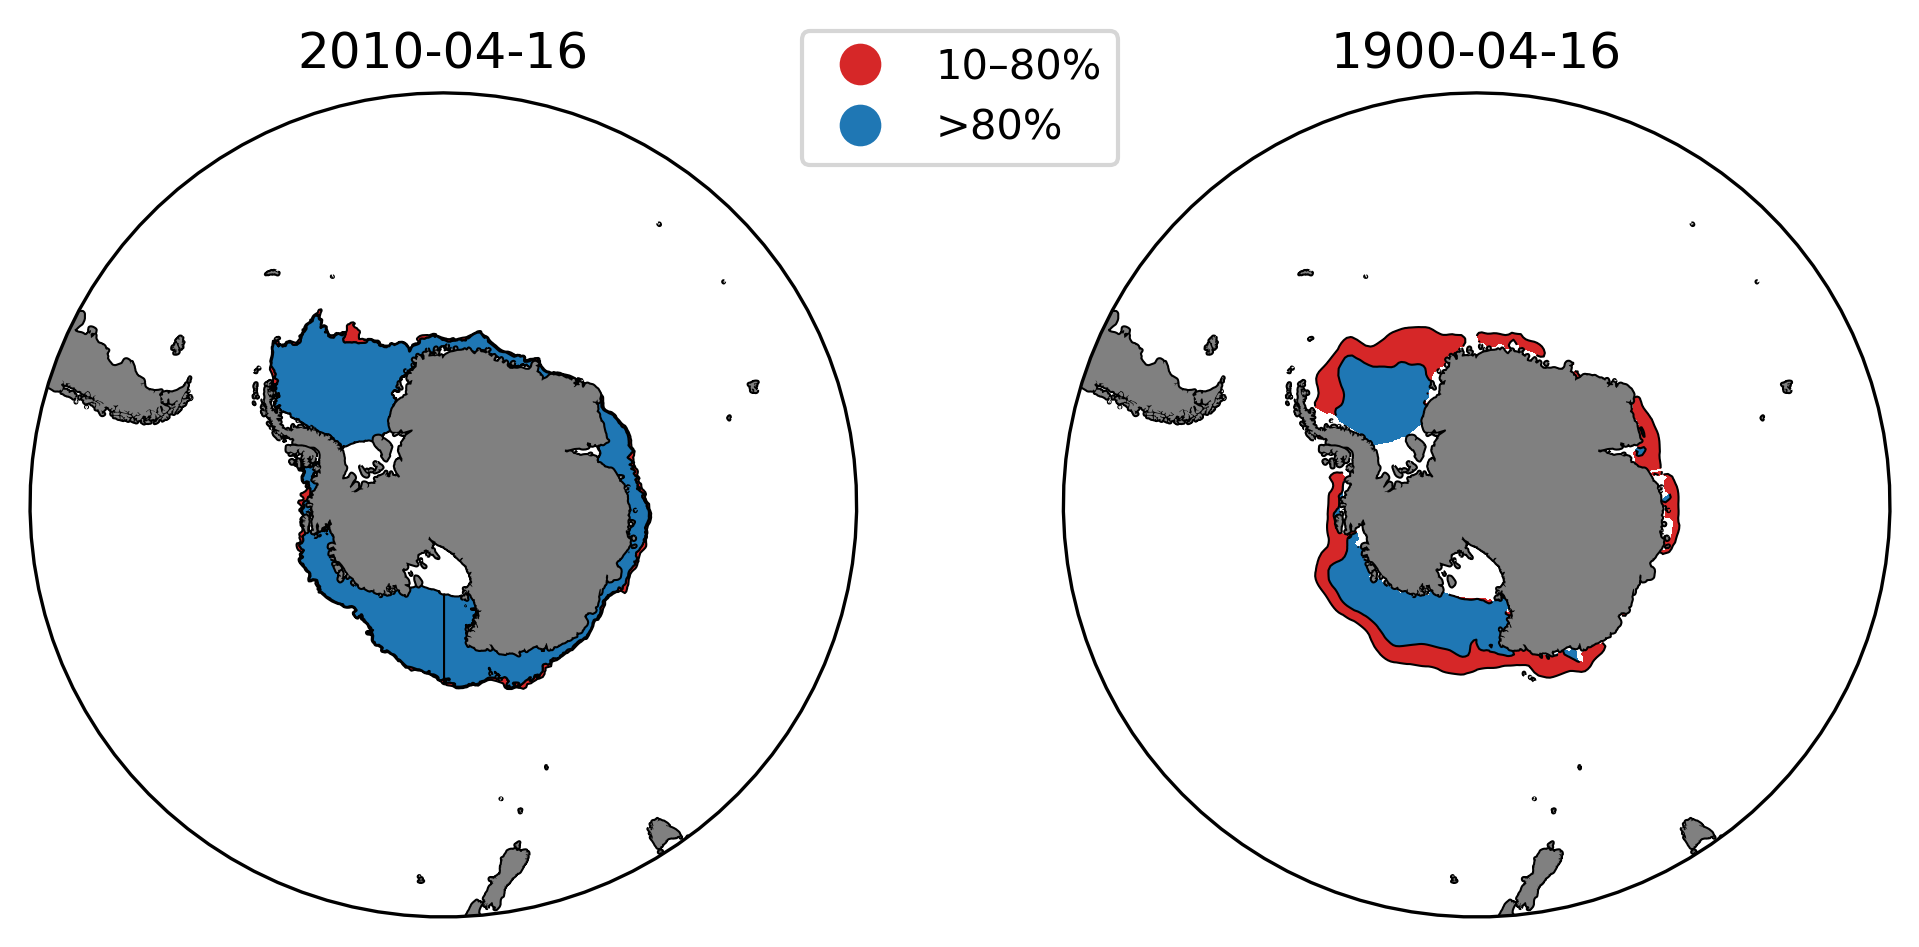

In [14]:
# Aesthetics
bounds = [0.0, 0.1, 0.8, 1.0]
cmap = ListedColormap(["white", "tab:red", "tab:blue"])  
norm = mcolors.BoundaryNorm(bounds, cmap.N)


# Make figure
number_panels = 2
hemisphere = "south"
projection, extent = get_proj(hemisphere)
    
fig, axes = plt.subplots(
    ncols=number_panels,
    subplot_kw={'projection': projection},
    figsize=(4 * number_panels, 4),
    gridspec_kw={'wspace': 0.25, 'hspace': 0.15}
)

for ax in axes:
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                    edgecolor='none',
                                    facecolor='gray', linewidth=0.5)
    ax.coastlines(resolution='50m')
    ax.add_feature(land_50m)
    # Make a circle plot
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_title("NO DATA")


# fig, axes = make_fig(number_panels=2, hemisphere='south')



# Load shapefile
cmap_obs = ListedColormap(["tab:red", "tab:blue"])  
bounds_obs = [0, 1, 2]
norm_obs = BoundaryNorm(bounds_obs, cmap_obs.N)

shp_file = glob.glob(os.path.join(base_path, year, folder_name, "*.shp"))[0]
gdf = gpd.read_file(shp_file)

# Reproject
gdf_proj = gdf.to_crs(epsg=3031)

gdf_proj.plot(
    ax=axes[0],
    column="ICECODE",
    cmap=cmap_obs,
    norm=norm_obs,
    edgecolor="black",
    linewidth=0.5,
    legend=True, 
    figsize=(8, 8),
)

leg = axes[0].get_legend()
for text, new_label in zip(leg.get_texts(), ['10–80%', '>80%']):
    text.set_text(new_label)
leg.set_loc('upper center')
leg.set_bbox_to_anchor((1.125, 1.1))
axes[0].set_title(f"{year}-{month}-{day}")

ds.sel(time=t0)['aice_m'].plot.contourf(
    ax=axes[1],
    x="lon",
    y="lat",
    levels=bounds,  
    cmap=cmap,
    norm=norm,
    transform=ccrs.PlateCarree(),
    add_colorbar=False
)

cs = ds.sel(time=t0)['aice_m'].plot.contour(
    ax=axes[1],
    x="lon",
    y="lat",
    levels=bounds[1:],  
    colors='k',    
    linewidths=0.5,
    transform=ccrs.PlateCarree()
)

axes[1].set_title(t_str)

### Time series for one year

In [40]:
from tqdm.notebook import tqdm 
import calendar
if calendar.isleap(int(year)):
    days_of_year = np.arange(1, 367, 1)
else:
    days_of_year = np.arange(1, 366, 1)
    
base_path = "/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/"

year = '2011'
ice_charts_miz = []
ice_charts_inner = []
for day_of_year in tqdm(days_of_year):
    print(day_of_year)
    folder_name = f"nic_miz{year}{day_of_year:03d}sc_pl_a"
    get_ice_charts_data(base_path, folder_name, year)
    shp_file = glob.glob(os.path.join(base_path, year, folder_name, "*.shp"))
    
    try:
        gdf = gpd.read_file(shp_file[0])
        areas = gdf.groupby("ICECODE")["SHAPE_Area"].sum()
        ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
        ice_charts_inner.append(areas.get(1, 0))
    except Exception as e:
        print(f"Error reading shapefile for day {day_of_year}: {e} — skipping.")
        ice_charts_miz.append(np.nan)     # use .get() to handle missing codes
        ice_charts_inner.append(np.nan)
        continue
    # gdf = gpd.read_file(shp_file)
    # areas = gdf.groupby("ICECODE")["SHAPE_Area"].sum()
    # # print(area_by_code)
    # ice_charts_miz.append(areas[0])
    # ice_charts_inner.append(areas[1])

  0%|          | 0/365 [00:00<?, ?it/s]

1
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011001sc_pl_a already exists — skipping download & extraction.
2
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011002sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

3
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011003sc_pl_a already exists — skipping download & extraction.
4
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011004sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

5
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011005sc_pl_a already exists — skipping download & extraction.
6
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011006sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

7
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011007sc_pl_a already exists — skipping download & extraction.
8
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011008sc_pl_a already exists — skipping download & extraction.
9
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011009sc_pl_a already exists — skipping download & extraction.
10
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011010sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

11
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011011sc_pl_a already exists — skipping download & extraction.
12
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011012sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

13
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011013sc_pl_a already exists — skipping download & extraction.
14
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011014sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

15
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011015sc_pl_a already exists — skipping download & extraction.
16
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011016sc_pl_a already exists — skipping download & extraction.
17
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011017sc_pl_a already exists — skipping download & extraction.
18
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011018sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

19
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011019sc_pl_a already exists — skipping download & extraction.
20
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011020sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

21
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011021sc_pl_a already exists — skipping download & extraction.
22
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011022sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

23
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011023sc_pl_a already exists — skipping download & extraction.
24
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011024sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

25
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011025sc_pl_a already exists — skipping download & extraction.
26
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011026sc_pl_a already exists — skipping download & extraction.
27
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011027sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

28
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011028sc_pl_a already exists — skipping download & extraction.
29
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011029sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

30
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011030sc_pl_a already exists — skipping download & extraction.
31
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011031sc_pl_a already exists — skipping download & extraction.
32
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011032sc_pl_a already exists — skipping download & extraction.
33
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011033sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

34
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011034sc_pl_a already exists — skipping download & extraction.
35
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011035sc_pl_a already exists — skipping download & extraction.
36
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011036sc_pl_a already exists — skipping download & extraction.
37
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011037sc_pl_a already exists — skipping download & extraction.
38
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011038sc_pl_a already exists — skipping download & extraction.
39
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011039sc_pl_a already exists — skipping download & extraction.
40
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011040sc_pl_a already exists — skipping download & extraction.
41
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarc

/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

43
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011043sc_pl_a already exists — skipping download & extraction.
44
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011044sc_pl_a already exists — skipping download & extraction.
45
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011045sc_pl_a already exists — skipping download & extraction.
46
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011046sc_pl_a already exists — skipping download & extraction.
47
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011047sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

48
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011048sc_pl_a already exists — skipping download & extraction.
49
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011049sc_pl_a already exists — skipping download & extraction.
50
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011050sc_pl_a already exists — skipping download & extraction.
51
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011051sc_pl_a already exists — skipping download & extraction.
52
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011052sc_pl_a already exists — skipping download & extraction.
53
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011053sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

54
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011054sc_pl_a already exists — skipping download & extraction.
55
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011055sc_pl_a already exists — skipping download & extraction.
56
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011056sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

57
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011057sc_pl_a already exists — skipping download & extraction.
58
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011058sc_pl_a already exists — skipping download & extraction.
59
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011059sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

60
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011060sc_pl_a already exists — skipping download & extraction.
61
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011061sc_pl_a already exists — skipping download & extraction.
62
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011062sc_pl_a already exists — skipping download & extraction.
63
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011063sc_pl_a already exists — skipping download & extraction.
64
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011064sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

65
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011065sc_pl_a already exists — skipping download & extraction.
66
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011066sc_pl_a already exists — skipping download & extraction.
67
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011067sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

68
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011068sc_pl_a already exists — skipping download & extraction.
69
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011069sc_pl_a already exists — skipping download & extraction.
70
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011070sc_pl_a already exists — skipping download & extraction.
71
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011071sc_pl_a already exists — skipping download & extraction.
72
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011072sc_pl_a already exists — skipping download & extraction.
73
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011073sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

74
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011074sc_pl_a already exists — skipping download & extraction.
75
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011075sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

76
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011076sc_pl_a already exists — skipping download & extraction.
77
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011077sc_pl_a already exists — skipping download & extraction.
78
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011078sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

79
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011079sc_pl_a already exists — skipping download & extraction.
80
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011080sc_pl_a already exists — skipping download & extraction.
81
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011081sc_pl_a already exists — skipping download & extraction.
82


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011082sc_pl_a already exists — skipping download & extraction.
83
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011083sc_pl_a already exists — skipping download & extraction.
84
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011084sc_pl_a already exists — skipping download & extraction.
85
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011085sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

86
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011086sc_pl_a already exists — skipping download & extraction.
87
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011087sc_pl_a already exists — skipping download & extraction.
88


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011088sc_pl_a already exists — skipping download & extraction.
89
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011089sc_pl_a already exists — skipping download & extraction.
90


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011090sc_pl_a already exists — skipping download & extraction.
91
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011091sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

92
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011092sc_pl_a already exists — skipping download & extraction.
93
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011093sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

94
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011094sc_pl_a already exists — skipping download & extraction.
95
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011095sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

96
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011096sc_pl_a already exists — skipping download & extraction.
97
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011097sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

98
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011098sc_pl_a already exists — skipping download & extraction.
99
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011099sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

100
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011100sc_pl_a already exists — skipping download & extraction.
101
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011101sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


102
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011102sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


103
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011103sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


104
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011104sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


105
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011105sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


106
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011106sc_pl_a already exists — skipping download & extraction.
107
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011107sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

108
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011108sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


109
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011109sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


110
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011110sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


111
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011111sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


112
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011112sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


113
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011113sc_pl_a already exists — skipping download & extraction.
114
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011114sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

115
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011115sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


116
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011116sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

117
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011117sc_pl_a already exists — skipping download & extraction.
118
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011118sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


119
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011119sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


120
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011120sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


121
URL does not exist (https://noaadata.apps.nsidc.org/NOAA/G10017/south/2011/nic_miz2011121sc_pl_a.zip) — skipping download.
Error reading shapefile for day 121: list index out of range — skipping.
122
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011122sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


123
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011123sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


124
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011124sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


125
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011125sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


126
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011126sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


127
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011127sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


128
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011128sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

129
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011129sc_pl_a already exists — skipping download & extraction.
130
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011130sc_pl_a already exists — skipping download & extraction.
131


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011131sc_pl_a already exists — skipping download & extraction.
132
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011132sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


133
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011133sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


134
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011134sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

135
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011135sc_pl_a already exists — skipping download & extraction.
136
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011136sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

137
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011137sc_pl_a already exists — skipping download & extraction.
138
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011138sc_pl_a already exists — skipping download & extraction.
139
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011139sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


140
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011140sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

141
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011141sc_pl_a already exists — skipping download & extraction.
142
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011142sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

143
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011143sc_pl_a already exists — skipping download & extraction.
144
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011144sc_pl_a already exists — skipping download & extraction.
145
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011145sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

146
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011146sc_pl_a already exists — skipping download & extraction.
147
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011147sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

148
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011148sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


149
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011149sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


150
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011150sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


151
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011151sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


152
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011152sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


153
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011153sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


154
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011154sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

155
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011155sc_pl_a already exists — skipping download & extraction.
156
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011156sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


157
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011157sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

158
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011158sc_pl_a already exists — skipping download & extraction.
159
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011159sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

160
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011160sc_pl_a already exists — skipping download & extraction.
161
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011161sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


162
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011162sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


163
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011163sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

164
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011164sc_pl_a already exists — skipping download & extraction.
165
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011165sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


166
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011166sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


167
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011167sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

168
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011168sc_pl_a already exists — skipping download & extraction.
169
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011169sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


170
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011170sc_pl_a already exists — skipping download & extraction.
171
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011171sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

172
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011172sc_pl_a already exists — skipping download & extraction.
173
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011173sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


174
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011174sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


175
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011175sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

176
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011176sc_pl_a already exists — skipping download & extraction.
177
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011177sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

178
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011178sc_pl_a already exists — skipping download & extraction.
179
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011179sc_pl_a already exists — skipping download & extraction.
180
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011180sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

181
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011181sc_pl_a already exists — skipping download & extraction.
182
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011182sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

183
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011183sc_pl_a already exists — skipping download & extraction.
184
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011184sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

185
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011185sc_pl_a already exists — skipping download & extraction.
186
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011186sc_pl_a already exists — skipping download & extraction.
187
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011187sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

188
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011188sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


189
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011189sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

190
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011190sc_pl_a already exists — skipping download & extraction.
191
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011191sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


192
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011192sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

193
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011193sc_pl_a already exists — skipping download & extraction.
194
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011194sc_pl_a already exists — skipping download & extraction.
195
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011195sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

196
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011196sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


197
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011197sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

198
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011198sc_pl_a already exists — skipping download & extraction.
199
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011199sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

200
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011200sc_pl_a already exists — skipping download & extraction.
201
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011201sc_pl_a already exists — skipping download & extraction.
202
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011202sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

203
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011203sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

204
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011204sc_pl_a already exists — skipping download & extraction.
205
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011205sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


206
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011206sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


207
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011207sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


208
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011208sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

209
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011209sc_pl_a already exists — skipping download & extraction.
210
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011210sc_pl_a already exists — skipping download & extraction.
211
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011211sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

212
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011212sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


213
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011213sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

214
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011214sc_pl_a already exists — skipping download & extraction.
215
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011215sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


216
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011216sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


217
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011217sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

218
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011218sc_pl_a already exists — skipping download & extraction.
219
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011219sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


220
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011220sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

221
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011221sc_pl_a already exists — skipping download & extraction.
222
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011222sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


223
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011223sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


224
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011224sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

225
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011225sc_pl_a already exists — skipping download & extraction.
226
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011226sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

227
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011227sc_pl_a already exists — skipping download & extraction.
228
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011228sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

229
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011229sc_pl_a already exists — skipping download & extraction.
230
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011230sc_pl_a already exists — skipping download & extraction.
231
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011231sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

232
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011232sc_pl_a already exists — skipping download & extraction.
233
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011233sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


234
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011234sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

235
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011235sc_pl_a already exists — skipping download & extraction.
236
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011236sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


237
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011237sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


238
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011238sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

239
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011239sc_pl_a already exists — skipping download & extraction.
240
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011240sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


241
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011241sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


242
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011242sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


243
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011243sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


244
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011244sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


245
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011245sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


246
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011246sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


247
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011247sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


248
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011248sc_pl_a already exists — skipping download & extraction.
249
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011249sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

250
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011250sc_pl_a already exists — skipping download & extraction.
251
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011251sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


252
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011252sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


253
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011253sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


254
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011254sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


255
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011255sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


256
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011256sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


257
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011257sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


258
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011258sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


259
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011259sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


260
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011260sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


261
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011261sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


262
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011262sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


263
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011263sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


264
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011264sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

265
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011265sc_pl_a already exists — skipping download & extraction.
266
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011266sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


267
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011267sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


268
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011268sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


269
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011269sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

270
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011270sc_pl_a already exists — skipping download & extraction.
271
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011271sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


272
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011272sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


273
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011273sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

274
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011274sc_pl_a already exists — skipping download & extraction.
275
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011275sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


276
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011276sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


277
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011277sc_pl_a already exists — skipping download & extraction.
278
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011278sc_pl_a already exists — skipping download & extraction.
279


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011279sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


280
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011280sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

281
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011281sc_pl_a already exists — skipping download & extraction.
282
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011282sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


283
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011283sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


284
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011284sc_pl_a already exists — skipping download & extraction.
285
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011285sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

286
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011286sc_pl_a already exists — skipping download & extraction.
287
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011287sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

288
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011288sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


289
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011289sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


290
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011290sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


291
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011291sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


292
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011292sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


293
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011293sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


294
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011294sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


295
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011295sc_pl_a already exists — skipping download & extraction.
296
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011296sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

297
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011297sc_pl_a already exists — skipping download & extraction.
298
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011298sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


299
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011299sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


300
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011300sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


301
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011301sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

302
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011302sc_pl_a already exists — skipping download & extraction.
303
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011303sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

304
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011304sc_pl_a already exists — skipping download & extraction.
305
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011305sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

306
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011306sc_pl_a already exists — skipping download & extraction.
307
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011307sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


308
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011308sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


309
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011309sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


310
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011310sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


311
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011311sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


312
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011312sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

313
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011313sc_pl_a already exists — skipping download & extraction.
314
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011314sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


315
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011315sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

316
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011316sc_pl_a already exists — skipping download & extraction.
317
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011317sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


318
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011318sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


319
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011319sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


320
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011320sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


321
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011321sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


322
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011322sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


323
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011323sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

324
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011324sc_pl_a already exists — skipping download & extraction.
325
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011325sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

326
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011326sc_pl_a already exists — skipping download & extraction.
327
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011327sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

328
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011328sc_pl_a already exists — skipping download & extraction.
329
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011329sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

330
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011330sc_pl_a already exists — skipping download & extraction.
331
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011331sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


332
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011332sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


333
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011333sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

334
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011334sc_pl_a already exists — skipping download & extraction.
335
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011335sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

336
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011336sc_pl_a already exists — skipping download & extraction.
337
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011337sc_pl_a already exists — skipping download & extraction.
338
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011338sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


339
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011339sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


340
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011340sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


341
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011341sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

342
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011342sc_pl_a already exists — skipping download & extraction.
343
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011343sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


344
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011344sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

345
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011345sc_pl_a already exists — skipping download & extraction.
346
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011346sc_pl_a already exists — skipping download & extraction.
347
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011347sc_pl_a already exists — skipping download & extraction.
348
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011348sc_pl_a already exists — skipping download & extraction.
349
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011349sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

350
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011350sc_pl_a already exists — skipping download & extraction.
351
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011351sc_pl_a already exists — skipping download & extraction.
352
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011352sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

353
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011353sc_pl_a already exists — skipping download & extraction.
354
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011354sc_pl_a already exists — skipping download & extraction.
355
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011355sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

356
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011356sc_pl_a already exists — skipping download & extraction.
357
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011357sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

358
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011358sc_pl_a already exists — skipping download & extraction.
359
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011359sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

360
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011360sc_pl_a already exists — skipping download & extraction.
361
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011361sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

362
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011362sc_pl_a already exists — skipping download & extraction.
363
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011363sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

364
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011364sc_pl_a already exists — skipping download & extraction.
365
/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2011/nic_miz2011365sc_pl_a already exists — skipping download & extraction.


/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_miz.append(areas.get(0, 0))     # use .get() to handle missing codes
/jobfs/156250703.gadi-pbs/ipykernel_3848008/326794000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ice_charts_inner.append(areas.get(1, 0))


In [45]:
day_of_year = 180
folder_name = f"nic_miz{year}{day_of_year:03d}sc_pl_a"
shp_file = glob.glob(os.path.join(base_path, folder_name, "*.shp"))[0]
gdf = gpd.read_file(shp_file)
gdf.groupby("ICECODE")["Shape_Area"].sum()

ICECODE
CT18    3.684203e+12
CT81    9.573349e+12
Name: Shape_Area, dtype: float64

In [ ]:
# gdf

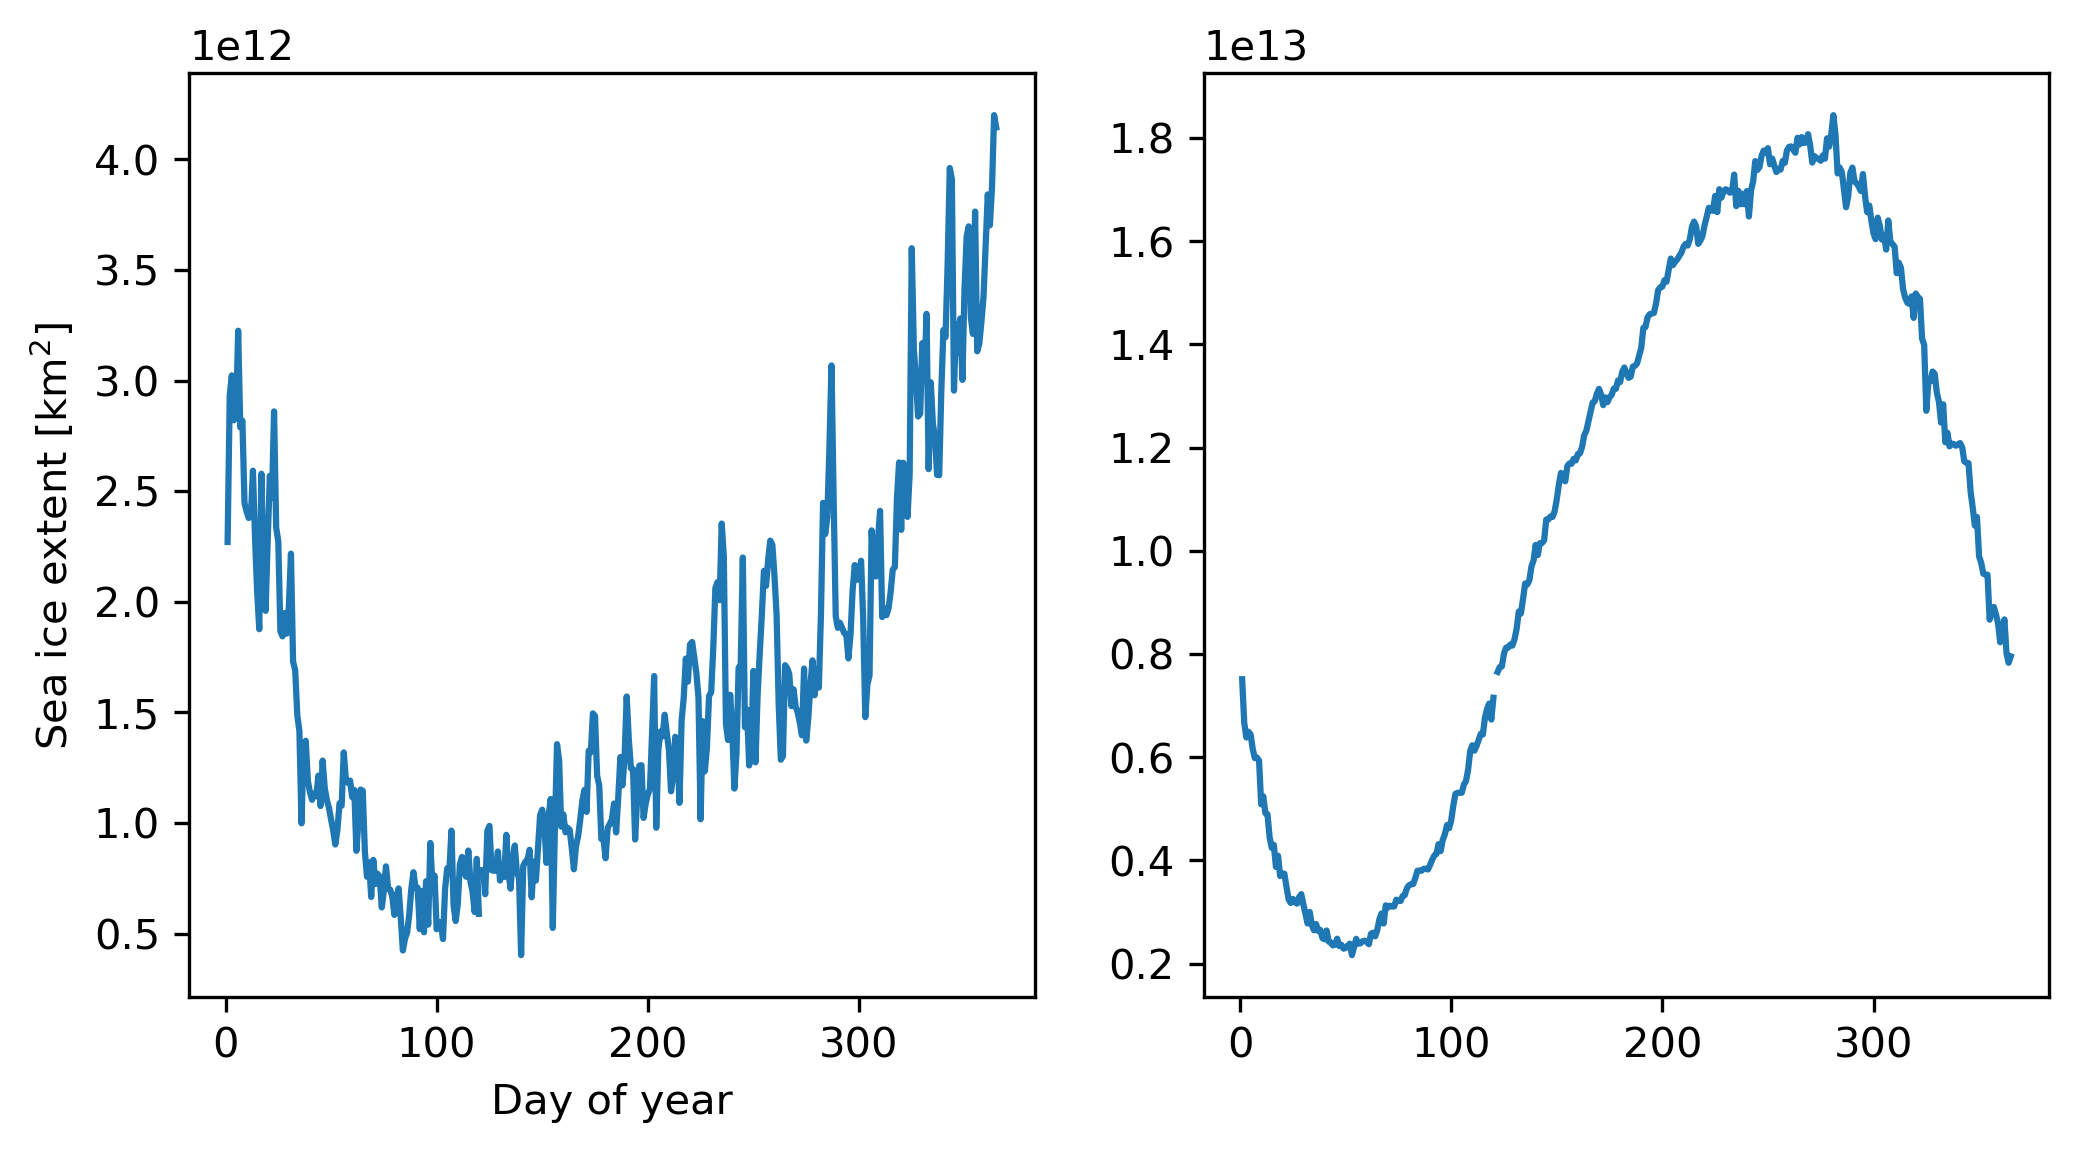

In [43]:
fig, axes = plt.subplots(
    ncols=2,
    figsize=(4 * number_panels, 4),
)

axes[0].plot(days_of_year, ice_charts_miz,
            label="MIZ"
)

axes[0].set_xlabel("Day of year")
axes[0].set_ylabel("Sea ice extent [km$^2$]")


axes[1].plot(days_of_year, ice_charts_inner,
            label="MIZ"
)


In [42]:
days_of_year

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

### Calculate climatology

In [14]:
ds_clim = ds.groupby('time.month').mean('time').compute()
ds_clim

<xarray.Dataset> Size: 59MB
Dimensions:        (month: 12, nj: 300, ni: 360)
Coordinates:
    TLON           (nj, ni) float64 864kB nan nan nan nan ... nan nan nan nan
    TLAT           (nj, ni) float64 864kB nan nan nan nan ... nan nan nan nan
    ULON           (nj, ni) float64 864kB nan nan nan nan ... nan nan nan nan
    ULAT           (nj, ni) float64 864kB nan nan nan nan ... nan nan nan nan
    NLON           (nj, ni) float64 864kB nan nan nan nan ... nan nan nan nan
    NLAT           (nj, ni) float64 864kB nan nan nan nan ... nan nan nan nan
    ELON           (nj, ni) float64 864kB nan nan nan nan ... nan nan nan nan
    ELAT           (nj, ni) float64 864kB nan nan nan nan ... nan nan nan nan
  * month          (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nj, ni
Data variables:
    aice_m         (month, nj, ni) float64 10MB nan nan nan nan ... nan nan nan
    wave_sig_ht_m  (month, nj, ni) float64 10MB nan nan nan nan ... nan nan nan
    fsdrad_m       (month, nj, ni) float64 10MB nan nan nan nan ... nan nan nan
    tarea          (month, nj, ni) float64 10MB nan nan nan nan ... nan nan nan
    HTE            (month, nj, ni) float64 10MB nan nan nan nan ... nan nan nan
Attributes: (12/21)
    title:                                    access-om3
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   CICE Sea Ice Model, unknown_ver...
    comment:                                  All years have exactly 365 days
    comment3:                                 seconds elapsed into model date...
    time_period_freq:                         month_1
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,,time: mean,time: mean,...
    intake_esm_attrs:variable_units:          days since 1900-01-01 00:00:00,...
    intake_esm_attrs:realm:                   seaIce
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_cice_1mon_mean_XXXX_...

### Load in observations (*Fraser et al., 2025*)

In [15]:
def ReadInAltika(version, year=2019):
    if version == '0.6':
        month_range = range(1,13)
        df = pd.concat((pd.read_csv('/home/566/nd0349/Fraser-2024/data/v0_6/' + str(year) + ("%02d" % (month,)) + '_output_v0_6.csv') 
                        for month in tqdm(month_range, total = len(month_range), desc = "Reading in Alex's data")),
                        ignore_index=True)
        
        df = df[['first_meas_time', 'swhAtMyEdge', 'lonAtMyEdge', 'latAtMyEdge', 'lonAtAltiKaEdge','latAtAltiKaEdge', 'lonAtInnerMIZ', 'latAtInnerMIZ', 'mizWidthAlongTrackFromMyEdge', 'mizWidthAlongTrackFromAltikaEdge']]
        
    
    elif version == '0.10':
        # Version 0.10
        df_raw = pd.read_csv('data/v0_10/' + str(year) + '_all_output_v0_10.csv')
        row_temp = df_raw.loc[0,:]
        row_temp.values
        # Fill the first row with temporary data
        df = pd.DataFrame([row_temp], columns = df_raw.columns)
        
        numberRows,NumberCols = df_raw.shape
        
        for i in range(numberRows):
            row_temp = df_raw.loc[i,:]
            row = pd.DataFrame([row_temp], columns = df_raw.columns)
            if  (row['too_many_switches_flag'].values == 0) & (row['hit_continent_flag'].values == 0) & (row['ice_edge_diff_flag'].values == 0) & (row['latAtInnerMIZ'].values < row['latAtAltiKaEdge'].values) & (row['latAtInnerMIZ'].values < row['latAtMyEdge'].values) & (np.abs(row['lonAtInnerMIZ'].values - row['lonAtAltiKaEdge'].values) < 10):
                df = pd.concat([df,row])
        df.drop([0])
        df = df[['first_meas_time', 'swhAtMyEdge', 'lonAtMyEdge', 'latAtMyEdge', 'lonAtAltiKaEdge','latAtAltiKaEdge', 'lonAtInnerMIZ', 'latAtInnerMIZ', 'mizWidthAlongTrackFromMyEdge', 'mizWidthAlongTrackFromAltikaEdge']]
    elif version == '0.11':
        # Version 0.11
        df_raw = pd.read_csv('data/v0_11/' + str(year) + '_all_output_v0_11.csv')
        row_temp = df_raw.loc[0,:]
        row_temp.values
        # Fill the first row with temporary data
        df = pd.DataFrame([row_temp], columns = df_raw.columns)
        
        numberRows,NumberCols = df_raw.shape
        
        for i in range(numberRows):
            row_temp = df_raw.loc[i,:]
            row = pd.DataFrame([row_temp], columns = df_raw.columns)
            if  (row['too_many_switches_flag'].values == 0) & (row['hit_continent_flag'].values == 0) & (row['ice_edge_diff_flag'].values == 0) & (row['latAtInnerMIZ'].values < row['latAtAltiKaEdge'].values) & (row['latAtInnerMIZ'].values < row['latAtMyEdge'].values) & (np.abs(row['lonAtInnerMIZ'].values - row['lonAtAltiKaEdge'].values) < 10):
                df = pd.concat([df,row])
        df.drop([0])
        df = df[['first_meas_time', 'swhAtMyEdge', 'lonAtMyEdge', 'latAtMyEdge', 'lonAtAltiKaEdge','latAtAltiKaEdge', 'lonAtInnerMIZ', 'latAtInnerMIZ', 'mizWidthAlongTrackFromMyEdge', 'mizWidthAlongTrackFromAltikaEdge']]
    elif version == '0.12':
        # Version 0.12
        df_raw = pd.read_csv('data/v0_12/' + str(year) + '_all_output_v0_12.csv')
        row_temp = df_raw.loc[0,:]
        row_temp.values
        # Fill the first row with temporary data
        df = pd.DataFrame([row_temp], columns = df_raw.columns)
        
        numberRows,NumberCols = df_raw.shape
        
        for i in range(numberRows):
            row_temp = df_raw.loc[i,:]
            row = pd.DataFrame([row_temp], columns = df_raw.columns)
            if  (row['too_many_switches_flag'].values == 0) & (row['hit_continent_flag'].values == 0) & (row['ice_edge_diff_flag'].values == 0) & (row['latAtInnerMIZ'].values < row['latAtAltiKaEdge'].values) & (row['latAtInnerMIZ'].values < row['latAtMyEdge'].values) & (np.abs(row['lonAtInnerMIZ'].values - row['lonAtAltiKaEdge'].values) < 10):
                df = pd.concat([df,row])
        df.drop([0])
        df = df[['first_meas_time', 'swhAtMyEdge', 'lonAtMyEdge', 'latAtMyEdge', 'lonAtAltiKaEdge','latAtAltiKaEdge', 'lonAtInnerMIZ', 'latAtInnerMIZ', 'mizWidthAlongTrackFromMyEdge', 'mizWidthAlongTrackFromAltikaEdge']]
        
    elif version == '0.15':
        # Version 0.15
        df_raw = pd.read_csv('/home/566/nd0349/Fraser-2024/data/v0_15/' + str(year) + '_all_output_v0_15.csv')
        row_temp = df_raw.loc[0,:]
        row_temp.values
        # Fill the first row with temporary data
        df = pd.DataFrame([row_temp], columns = df_raw.columns)
        
        numberRows,NumberCols = df_raw.shape
        
        for i in range(numberRows):
            row_temp = df_raw.loc[i,:]
            row = pd.DataFrame([row_temp], columns = df_raw.columns)
            if  (row['too_many_switches_flag'].values == 0) & (row['hit_continent_flag'].values == 0) & (row['ice_edge_diff_flag'].values == 0) & (row['latAtInnerMIZ'].values < row['latAtAltiKaEdge'].values) & (row['latAtInnerMIZ'].values < row['latAtMyEdge'].values) & (np.abs(row['lonAtInnerMIZ'].values - row['lonAtAltiKaEdge'].values) < 10):
                df = pd.concat([df,row])
        df.drop([0])
        
    # Add dates to dataframe
    df['date'] = pd.to_datetime(df["first_meas_time"])#, format='%Y-%m-%d').dt.round("d")
    df['day'] = pd.to_datetime(df['date']).dt.day
    df['year'] = pd.to_datetime(df['date']).dt.year
    df['month'] = pd.to_datetime(df['date']).dt.month
    return df

In [16]:
from tqdm.notebook import tqdm

years = range(2013, 2024)
dfs = []

# swh_min = 10**-12
# swh_max = 100
# miz_max = 10000
# miz_min = -10**-12

for year in tqdm(years):
    # print(year)
    df = pd.DataFrame(ReadInAltika(version='0.15', year=year))
    df = df[['first_meas_time', 'swhAtMyEdge', 'lonAtMyEdge', 'latAtMyEdge', 'lonAtAltiKaEdge','latAtAltiKaEdge', 'lonAtInnerMIZ', 'latAtInnerMIZ', 'mizWidthAlongTrackFromMyEdge', 'mizWidthAlongTrackFromAltikaEdge']]
    df['date'] = pd.to_datetime(df["first_meas_time"]).dt.date # , format='%Y-%m-%d %H:%M:%S.%f').dt.date
    df['day'] = pd.to_datetime(df['date']).dt.day
    df['year'] = pd.to_datetime(df['date']).dt.year
    df['month'] = pd.to_datetime(df['date']).dt.month
    df['mizwidth_lat'] = abs(df['latAtAltiKaEdge'] - df['latAtInnerMIZ'])*111.32 # Alex's conversion from latitudes to km

    dfs.append(df)
# Combine into one dataframe
df_all = pd.concat(dfs, ignore_index=True)
# df_tmp = df_all.copy()
# condition_met_df = (df_tmp['swhAtMyEdge'] < swh_max) & (df_tmp['swhAtMyEdge'] > swh_min) & (df_tmp['mizWidthAlongTrackFromAltikaEdge'] < miz_max) & (df_tmp['mizWidthAlongTrackFromAltikaEdge'] > miz_min)
# df_all = df_tmp.where(condition_met_df)
df_all.head()

  0%|          | 0/11 [00:00<?, ?it/s]

,first_meas_time,swhAtMyEdge,lonAtMyEdge,latAtMyEdge,lonAtAltiKaEdge,latAtAltiKaEdge,lonAtInnerMIZ,latAtInnerMIZ,mizWidthAlongTrackFromMyEdge,mizWidthAlongTrackFromAltikaEdge,date,day,year,month,mizwidth_lat
0,2013-03-14 06:29:45.868806,1.687726,144.227909,-65.075224,143.941111,-65.370226,143.705466,-65.611763,64.580466,29.058073,2013-03-14,14,2013,3,26.887899
1,2013-03-14 06:29:45.868806,1.687726,144.227909,-65.075224,143.941111,-65.370226,143.705466,-65.611763,64.580466,29.058073,2013-03-14,14,2013,3,26.887899
2,2013-03-14 07:20:03.662676,1.903122,1.938063,-68.331988,2.380483,-68.678470,3.743463,-69.687394,167.533329,124.858594,2013-03-14,14,2013,3,112.313420
3,2013-03-14 08:10:21.720821,2.011015,119.110686,-65.043592,118.766595,-65.397606,118.733795,-65.434442,47.005832,4.380543,2013-03-14,14,2013,3,4.100584
4,2013-03-14 09:00:39.517474,1.635128,339.407504,-70.235543,340.841359,-71.139443,341.304206,-71.418344,149.157700,35.263525,2013-03-14,14,2013,3,31.047259


In [17]:
# Average monthly
df_clim = df_all.groupby('month').mean(numeric_only=True)
df_clim.head()

,swhAtMyEdge,lonAtMyEdge,latAtMyEdge,lonAtAltiKaEdge,latAtAltiKaEdge,lonAtInnerMIZ,latAtInnerMIZ,mizWidthAlongTrackFromMyEdge,mizWidthAlongTrackFromAltikaEdge,day,year,mizwidth_lat
month,,,,,,,,,,,,
1,2.184007,166.430348,-67.106528,166.185463,-67.260895,166.206238,-67.713897,78.311200,55.655682,14.763496,2018.092891,50.428206
2,2.253309,180.162562,-68.080052,180.173450,-68.236231,180.146264,-68.592000,65.544679,44.085870,14.367722,2017.931523,39.604290
3,2.410002,188.731202,-68.150036,188.702315,-68.448503,188.702460,-68.930079,97.158424,60.083969,17.333527,2017.903988,53.609025
4,2.739153,179.746850,-66.636031,179.546947,-66.894250,179.511327,-67.828733,148.234037,114.969863,16.038139,2017.868374,104.026625
5,2.960517,176.019193,-64.907779,175.969736,-65.193372,175.948523,-66.395179,181.485997,145.995876,16.094722,2017.953533,133.785139


In [18]:
def _get_var(ds, names):
    """Return the first matching variable name in ds."""
    for n in names:
        if n in ds:
            return n
    raise KeyError(f"None of the variables {names} found in dataset.")


def _get_mask(ds, definition, hemisphere, threshold=None):
    # Set defaults for each definition
    defaults = {'wave_sig_ht': 0.05, 'aice': 0.8, 'fsdrad': 200}
    if threshold is None:
        try:
            threshold = defaults[definition]
        except KeyError:
            raise ValueError(f"Unknown definition: {definition}")

    # Example for aice
    aice_var = _get_var(ds, ['aice_m', 'aice'])
    wave_var = _get_var(ds, ['wave_sig_ht_m', 'wave_sig_ht'])
    fsd_var = _get_var(ds, ['fsdrad_m', 'fsdrad'])
    
    # Hemisphere mask
    if hemisphere == 'south':
        hemi_mask = ds['TLAT'] < 0
    elif hemisphere == 'north':
        hemi_mask = ds['TLAT'] > 0
    else:
        raise ValueError("hemisphere must be 'north' or 'south'")

    # Base ice presence mask
    base_mask = ds[aice_var] > 0.15

    # Definition-specific condition
    if definition == 'wave_sig_ht':
        cond = ds[wave_var] > threshold
    elif definition == 'aice':
        cond = ds[aice_var] < threshold
    elif definition == 'fsdrad':
        cond = ds[fsd_var] < threshold
    elif definition in ['SIE', 'SIA']:
        cond = base_mask
    else:
        raise ValueError(f"Unknown definition: {definition}")

    return base_mask & cond & hemi_mask

def _integrate_width(width, ds, method):
    if method == 'simple':
        return width.sum(dim='nj', skipna=True)
    elif method == 'weighted':
        aice_var = _get_var(ds, ['aice_m', 'aice'])
        return (width * ds[aice_var]).sum(dim='nj', skipna=True)
    else:
        raise ValueError(f"Unknown integration: {method}")

def _reduce_width(width, method, mask):
    if mask:
        width = width.where(width != 0)
    if method == 'median':
        return width.median(dim='ni', skipna=True)
    elif method == 'mean':
        return width.mean(dim='ni', skipna=True)
    else:
        raise ValueError(f"Unknown measure: {method}")

def calculate_miz_width(ds_cice, definition='wave', threshold=0.3, integration='simple', 
                        measure='median', mask=True, hemisphere='south', freq='monthly'):
    mask_2d = _get_mask(ds_cice, definition, hemisphere, threshold)
    
    miz_width_2d = ds_cice['HTE'].where(mask_2d) / 1000 # m to km
    miz_width_1d = _integrate_width(miz_width_2d, ds_cice, integration)
    miz_width_reduced = _reduce_width(miz_width_1d, measure, mask)

    if freq == 'monthly':
        coords = {'month': ds_cice['month']}
    elif freq == 'dayofyear':
        coords = {'dayofyear': ds_cice['dayofyear']}

    return xr.DataArray(
        miz_width_reduced,
        dims=miz_width_reduced.dims,
        coords=coords,
        name='miz_width',
        attrs={
            'units': 'km',
            'description': f'MIZ width ({definition})'
        }
    )

In [19]:
hemisphere='south'
antarctic_miz_width_wave = calculate_miz_width(ds_clim, definition='wave_sig_ht', hemisphere=hemisphere)
antarctic_miz_width_aice = calculate_miz_width(ds_clim, definition='aice', threshold=0.8, hemisphere=hemisphere)
antarctic_miz_width_fsdrad = calculate_miz_width(ds_clim, definition='fsdrad', threshold=200, hemisphere=hemisphere)

In [20]:
hemisphere='north'
arctic_miz_width_wave = calculate_miz_width(ds_clim, definition='wave_sig_ht', hemisphere=hemisphere)
arctic_miz_width_aice = calculate_miz_width(ds_clim, definition='aice', threshold=0.8, hemisphere=hemisphere)
arctic_miz_width_fsdrad = calculate_miz_width(ds_clim, definition='fsdrad', threshold=200, hemisphere=hemisphere)

### Plot the different MIZ width defintions

In [21]:
def figure(region=None):
    plt.rcParams['font.size'] = 12
    fig, axes = plt.subplots(ncols=2, figsize=(14,4), sharex=True, sharey=True)
    plt.subplots_adjust(wspace=0.12)

    axes[0].text(0.0, 1.03, 'a) ANTARCTIC', fontsize=12, fontweight='bold', transform=axes[0].transAxes)
    axes[1].text(0.0, 1.03, 'b) ARCTIC', fontsize=12, fontweight='bold', transform=axes[1].transAxes)
    # axes[2].text(0.0, 1.03, 'c) ACCESS-OM3 - ACCESS-OM2', fontsize=12, fontweight='bold', transform=axes[2].transAxes)

    # axes[0].text(0.99, 1.03, "ANTARCTIC", ha='right', fontsize=12, transform=axes[0].transAxes)
    # axes[1].text(0.99, 1.03, "ARCTIC", ha='right', fontsize=12, transform=axes[1].transAxes)
    
    for i, ax in enumerate(axes):
        ax.plot(np.arange(1,13,1), np.full(12,0), lw=0.5, c='k')
        ax.set_xlim([1,12])
        ax.set_xticks(np.arange(1,13,1))
        ax.set_xlabel('Month')
    
    # axes[0].set_ylabel('Sea ice volume tendency\n(x1000 km$^3$ day$^{-1}$)')
        
    return fig, axes

Text(0, 0.5, 'MIZ width [km]')

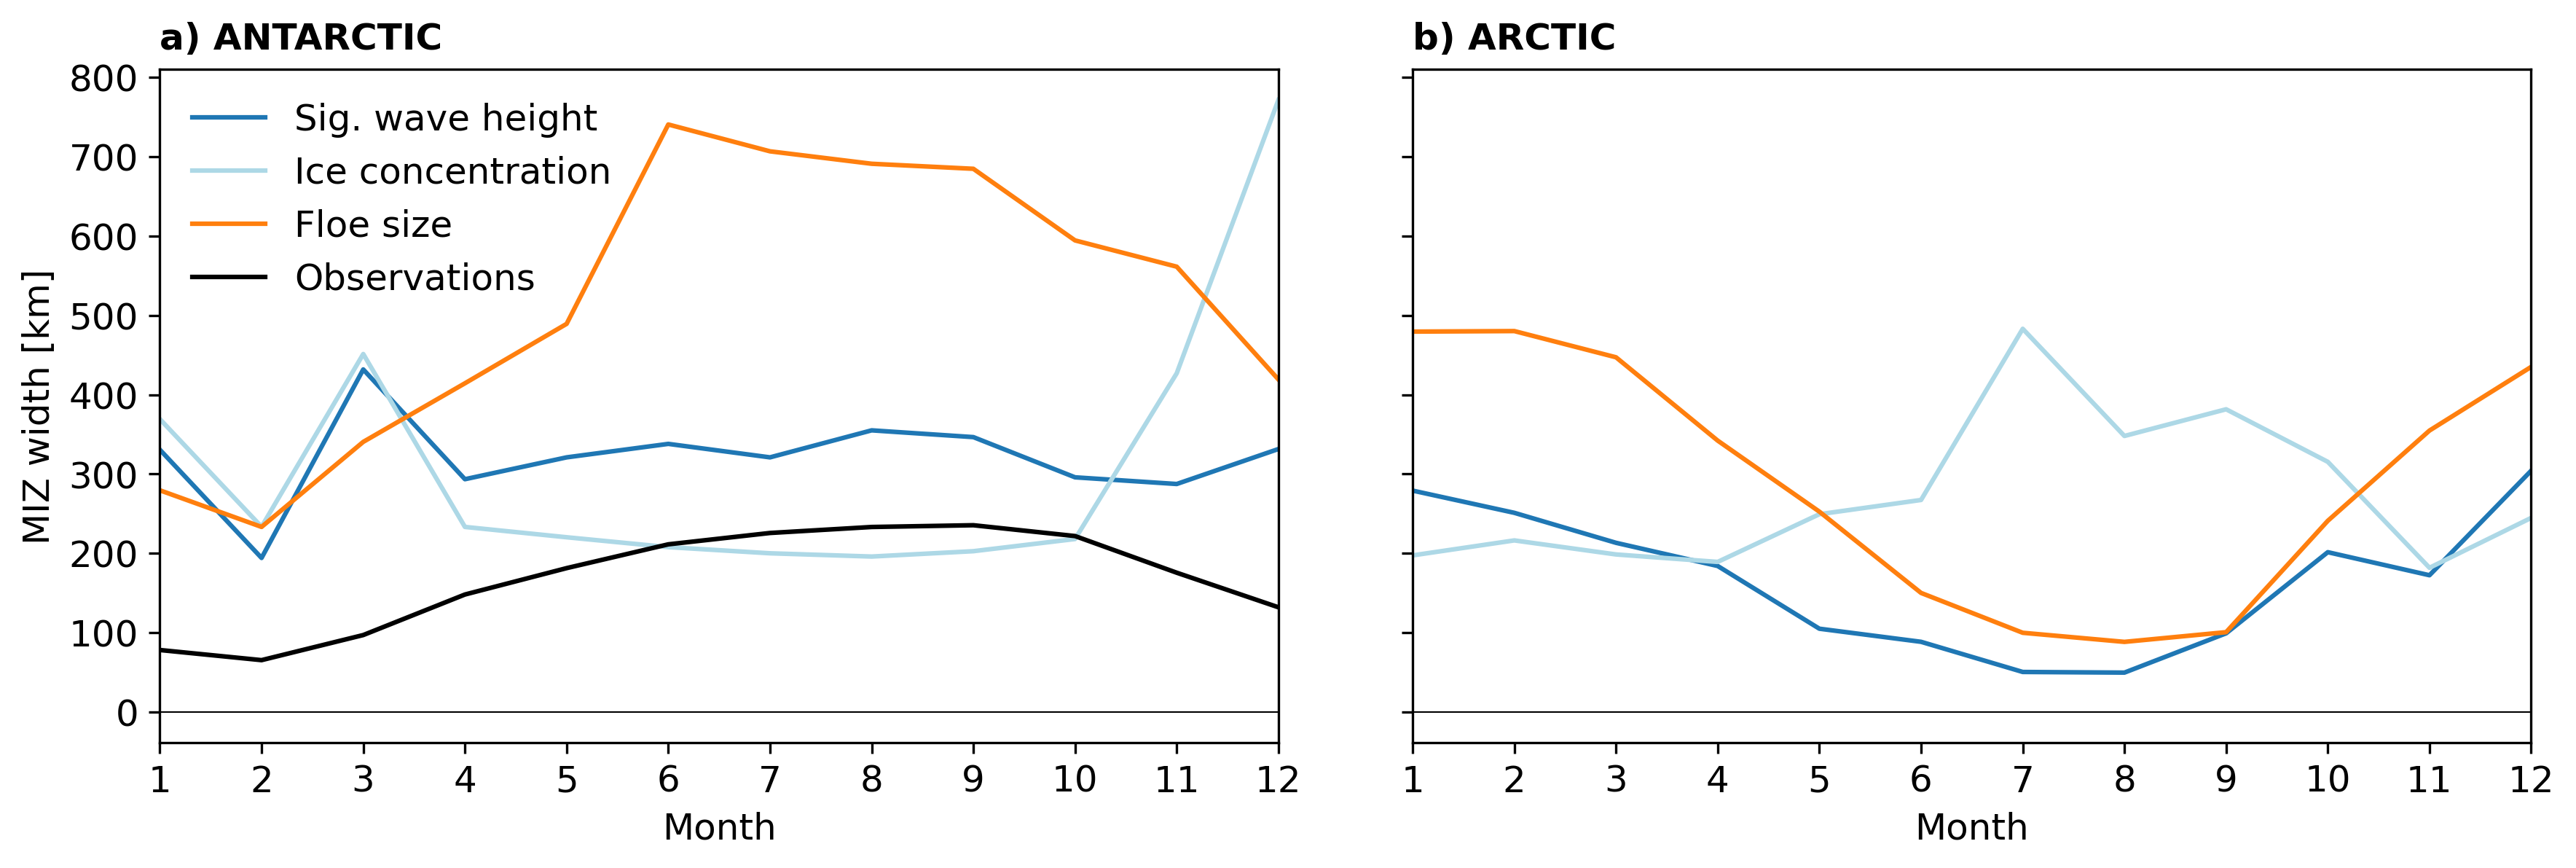

In [22]:
# region = 'ANTARCTICA'
fig, axes = figure()

x = np.arange(1, 13)
axes[0].plot(x, antarctic_miz_width_wave, label='Sig. wave height')
axes[0].plot(x, antarctic_miz_width_aice, label='Ice concentration', color='lightblue')
axes[0].plot(x, antarctic_miz_width_fsdrad, label='Floe size')
axes[0].plot(x, df_clim['mizWidthAlongTrackFromMyEdge'], color='k', label="Observations")

axes[0].legend(frameon=False, ncols=1, fontsize=12)

axes[1].plot(x, arctic_miz_width_wave, label='Sig. wave height')
axes[1].plot(x, arctic_miz_width_aice, label='Ice concentration', color='lightblue')
axes[1].plot(x, arctic_miz_width_fsdrad, label='Floe size')

axes[0].set_ylabel("MIZ width [km]")

### MIZ area

In [23]:
def _integrate_area(ds, mask, definition):
    if definition == "SIA":
        return ds['tarea']*ds['aice_m'].where(mask).sum(dim=['ni', 'nj'])
    else:
        return ds['tarea'].where(mask).sum(dim=['ni', 'nj'])

def calculate_area(ds_cice, definition='wave', threshold=0.05, integration='simple', 
                        measure='median', mask=True, method='naive', hemisphere='south'):
    mask_2d = _get_mask(ds_cice, definition, hemisphere, threshold)
    
    sea_ice_extent = _integrate_area(ds_cice, mask_2d, definition) * 1e-12

    if definition in ["wave_sig_ht", "aice", "fsdrad"]:
        name = "MIZ area"
    elif definition == "SIE":
        name = "Sea ice extent"
    elif definition == "SIA":
        name = "Sea ice area"

    return xr.DataArray(
        sea_ice_extent,
        dims=sea_ice_extent.dims,
        coords={'month': ds_cice['month']},
        name=name,
        attrs={
            'units': '10^6 km^2',
            'description': f'MIZ extent ({definition})'
        }
    )


In [24]:
# Calculate Antarctic extents
hemisphere = "south"
antarctic_sie = calculate_area(ds_clim, definition='SIE', hemisphere=hemisphere)
antarctic_sia = calculate_area(ds_clim, definition='SIA', hemisphere=hemisphere)
antarctic_miz_extent_wave = calculate_area(ds_clim, definition='wave_sig_ht', hemisphere=hemisphere)
antarctic_miz_extent_aice = calculate_area(ds_clim, definition='aice', threshold=0.8, hemisphere=hemisphere)
antarctic_miz_extent_fsdrad = calculate_area(ds_clim, definition='fsdrad', threshold=200, hemisphere=hemisphere)

In [25]:
# Calculate Arctic extents
hemisphere = "north"
arctic_sie = calculate_area(ds_clim, definition='SIE', hemisphere=hemisphere)
arctic_sia = calculate_area(ds_clim, definition='SIA', hemisphere=hemisphere)
arctic_miz_extent_wave = calculate_area(ds_clim, definition='wave_sig_ht', hemisphere=hemisphere)
arctic_miz_extent_aice = calculate_area(ds_clim, definition='aice', threshold=0.8, hemisphere=hemisphere)
arctic_miz_extent_fsdrad = calculate_area(ds_clim, definition='fsdrad', threshold=200, hemisphere=hemisphere)

Text(0, 0.5, 'Sea Ice Area [$10^6$ km$^2$]')

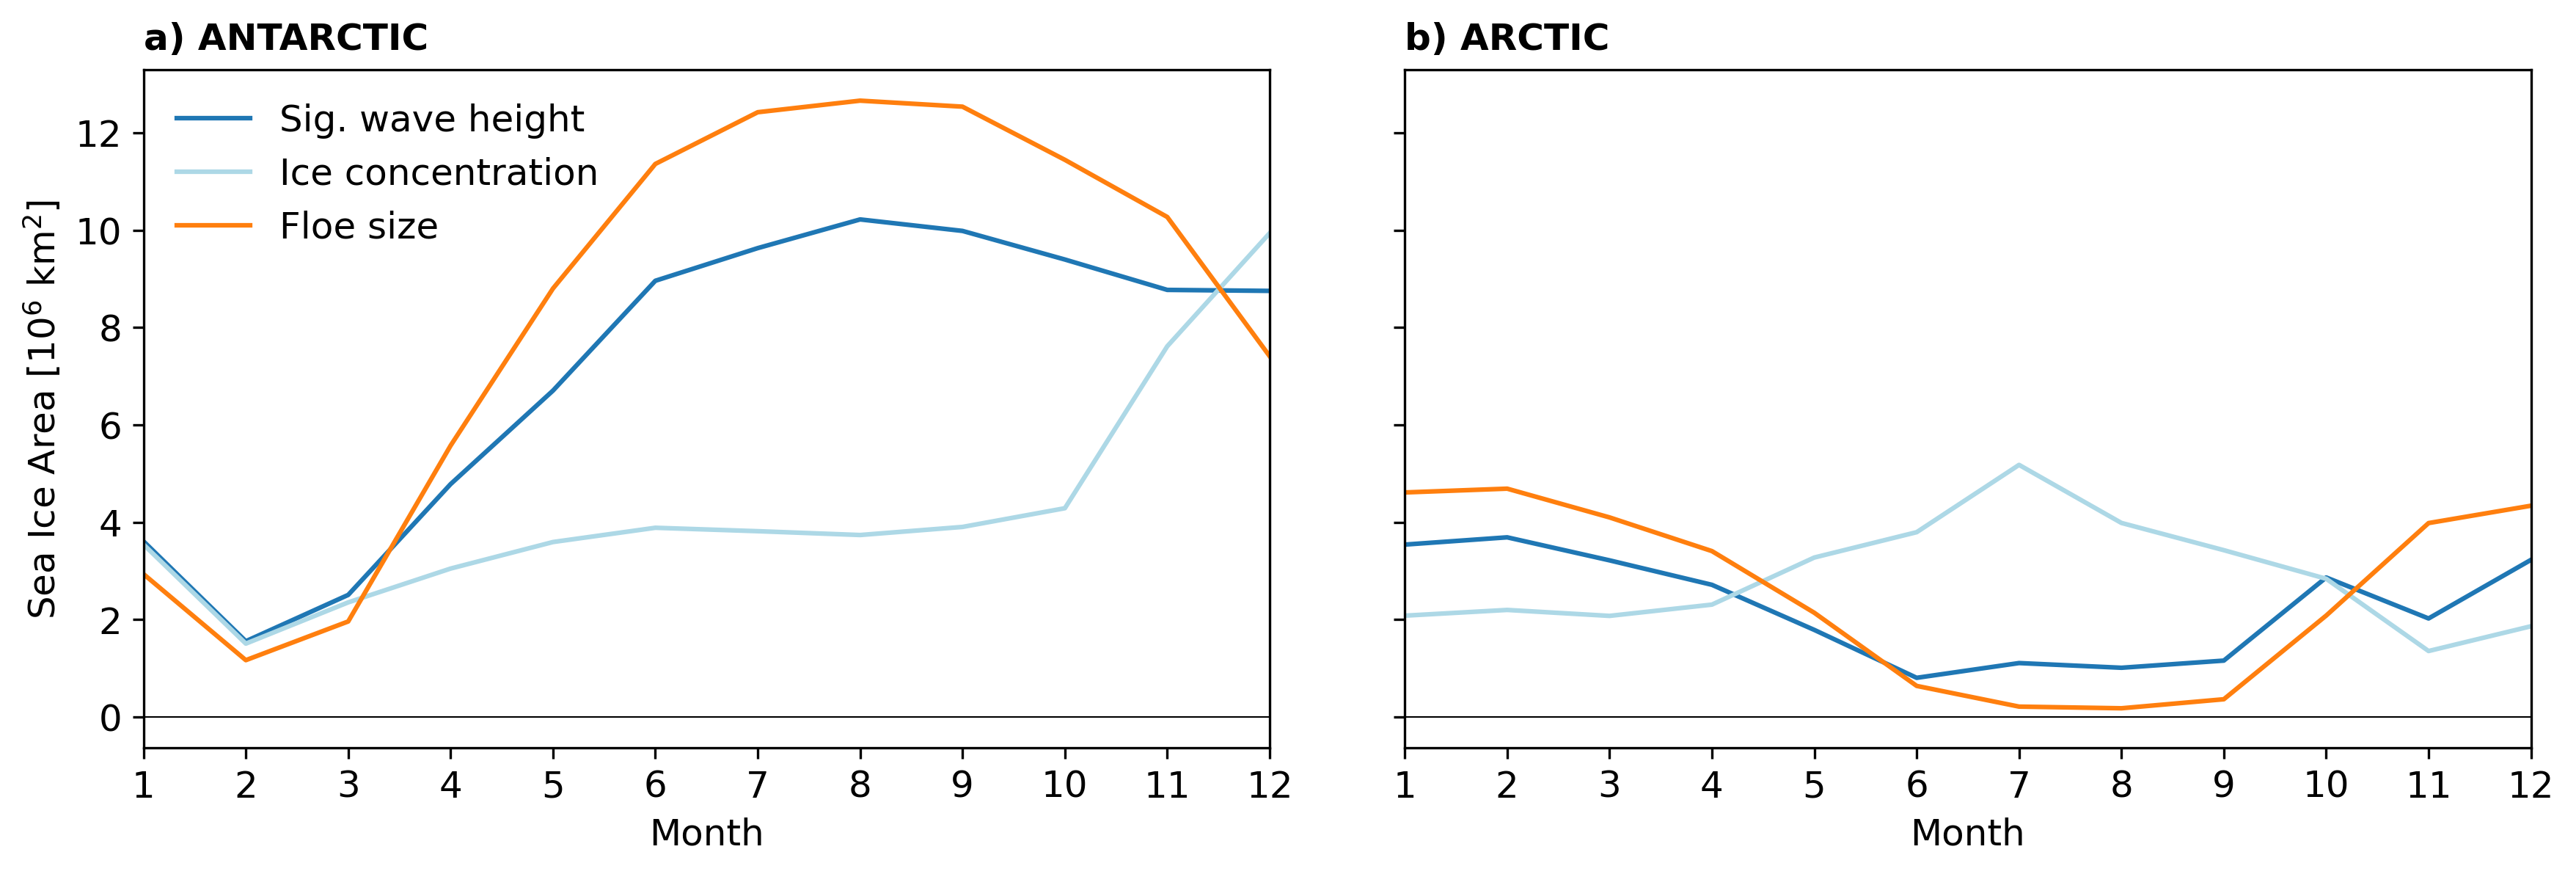

In [26]:
fig, axes = figure()

x = np.arange(1, 13)
axes[0].plot(x, antarctic_miz_extent_wave, label='Sig. wave height')
axes[0].plot(x, antarctic_miz_extent_aice, label='Ice concentration', color='lightblue')
axes[0].plot(x, antarctic_miz_extent_fsdrad, label='Floe size')

axes[0].legend(frameon=False, ncols=1, fontsize=12)

axes[1].plot(x, arctic_miz_extent_wave, label='Sig. wave height')
axes[1].plot(x, arctic_miz_extent_aice, label='Ice concentration', color='lightblue')
axes[1].plot(x, arctic_miz_extent_fsdrad, label='Floe size')

axes[0].set_ylabel("Sea Ice Area [$10^6$ km$^2$]")

### MIZ fraction

Text(0, 0.5, 'Marginal Ice Zone Fraction')

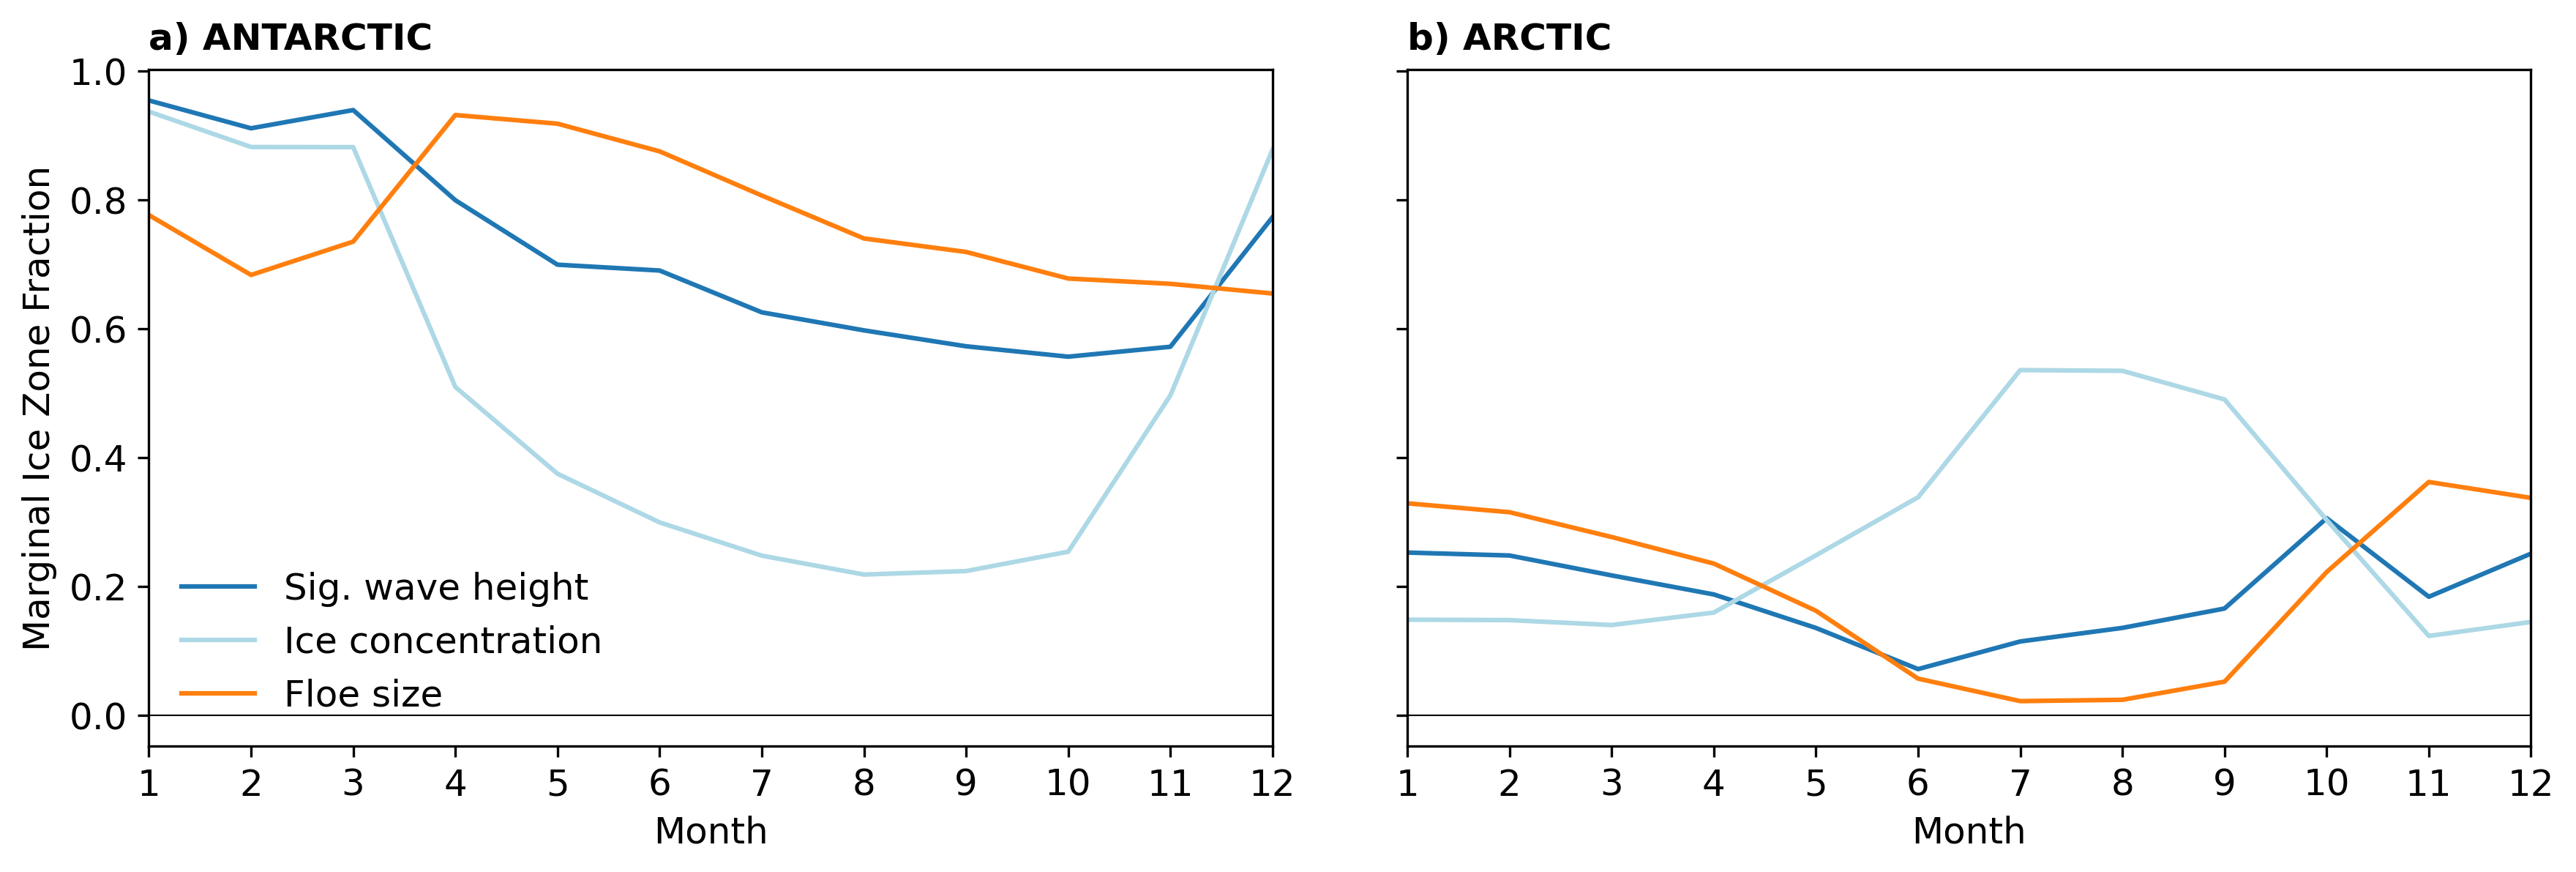

In [27]:
fig, axes = figure()

x = np.arange(1, 13)
axes[0].plot(x, antarctic_miz_extent_wave/antarctic_sie, label='Sig. wave height')
axes[0].plot(x, antarctic_miz_extent_aice/antarctic_sie, label='Ice concentration', color='lightblue')
axes[0].plot(x, antarctic_miz_extent_fsdrad/antarctic_sie, label='Floe size')

axes[0].legend(frameon=False, ncols=1, fontsize=12, loc="lower left")

axes[1].plot(x, arctic_miz_extent_wave/arctic_sie, label='Sig. wave height')
axes[1].plot(x, arctic_miz_extent_aice/arctic_sie, label='Ice concentration', color='lightblue')
axes[1].plot(x, arctic_miz_extent_fsdrad/arctic_sie, label='Floe size')

axes[0].set_ylabel("Marginal Ice Zone Fraction")

## Daily outputs

In [28]:
# Average monthly
df_all['doy'] = pd.to_datetime(df_all['date']).dt.dayofyear
df_doy = df_all.groupby('doy').mean(numeric_only=True)

In [29]:
ds_daily = datastore.search(variable=["aice", "wave_sig_ht", "fsdrad"], frequency="1day").to_dask(
    xarray_combine_by_coords_kwargs = dict( # These kwargs can make things faster
        compat="override",
        data_vars="minimal",
        coords="minimal",
    ),
    xarray_open_kwargs = dict(
        chunks={"nj": -1, "ni": -1}, # Good for spatial operations, but not temporal
        decode_timedelta=True
    )
)
ds_grid = datastore.search(variable=["tarea", "HTE"], frequency="fx", realm="seaIce").to_dask().compute()
ds_grid

ds_daily = xr.merge([ds_daily, ds_grid])
ds_daily = ds_daily.isel(time=slice(60,-1))
ds_daily

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/source.py:308: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(


<xarray.Dataset> Size: 2GB
Dimensions:      (time: 728, nj: 300, ni: 360)
Coordinates:
  * time         (time) object 6kB 1900-03-02 12:00:00 ... 1902-02-27 12:00:00
    TLON         (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan
    TLAT         (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan
    ULON         (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan
    ULAT         (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan
    NLON         (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan
    NLAT         (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan
    ELON         (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan
    ELAT         (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan
Dimensions without coordinates: nj, ni
Data variables:
    fsdrad       (time, nj, ni) float64 629MB dask.array<chunksize=(15, 300, 360), meta=np.ndarray>
    aice         (time, nj, ni) float64 629MB dask.array<chunksize=(15, 300, 360), meta=np.ndarray>
    wave_sig_ht  (time, nj, ni) float64 629MB dask.array<chunksize=(15, 300, 360), meta=np.ndarray>
    tarea        (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan
    HTE          (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan
Attributes: (12/20)
    title:                                    access-om3
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   CICE Sea Ice Model, unknown_ver...
    comment:                                  All years have exactly 365 days
    time_period_freq:                         day_1
    time_axis_position:                       middle
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,time: mean,time: mean,ti...
    intake_esm_attrs:variable_units:          1,1,1,1,1,radians,radians,m,m,1...
    intake_esm_attrs:realm:                   seaIce
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_cice_1day_mean_XXXX_...

In [30]:
ds_doy = ds_daily.groupby('time.dayofyear').mean('time').compute()
ds_doy

<xarray.Dataset> Size: 2GB
Dimensions:      (dayofyear: 365, nj: 300, ni: 360)
Coordinates:
    TLON         (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan
    TLAT         (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan
    ULON         (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan
    ULAT         (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan
    NLON         (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan
    NLAT         (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan
    ELON         (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan
    ELAT         (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan
  * dayofyear    (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 360 361 362 363 364 365
Dimensions without coordinates: nj, ni
Data variables:
    fsdrad       (dayofyear, nj, ni) float64 315MB nan nan nan ... nan nan nan
    aice         (dayofyear, nj, ni) float64 315MB nan nan nan ... nan nan nan
    wave_sig_ht  (dayofyear, nj, ni) float64 315MB nan nan nan ... nan nan nan
    tarea        (dayofyear, nj, ni) float64 315MB nan nan nan ... nan nan nan
    HTE          (dayofyear, nj, ni) float64 315MB nan nan nan ... nan nan nan
Attributes: (12/20)
    title:                                    access-om3
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   CICE Sea Ice Model, unknown_ver...
    comment:                                  All years have exactly 365 days
    time_period_freq:                         day_1
    time_axis_position:                       middle
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,time: mean,time: mean,ti...
    intake_esm_attrs:variable_units:          1,1,1,1,1,radians,radians,m,m,1...
    intake_esm_attrs:realm:                   seaIce
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_cice_1day_mean_XXXX_...

In [31]:
hemisphere='south'
antarctic_miz_width_wave_d = calculate_miz_width(ds_doy, definition='wave_sig_ht', hemisphere=hemisphere, freq='dayofyear')
antarctic_miz_width_aice_d = calculate_miz_width(ds_doy, definition='aice', threshold=0.8, hemisphere=hemisphere, freq='dayofyear')
antarctic_miz_width_fsdrad_d = calculate_miz_width(ds_doy, definition='fsdrad', threshold=500, hemisphere=hemisphere, freq='dayofyear')

antarctic_miz_width_wave_d_eff = calculate_miz_width(ds_doy, definition='wave_sig_ht', hemisphere=hemisphere, freq='dayofyear', integration='weighted')

Text(0, 0.5, 'MIZ width [km]')

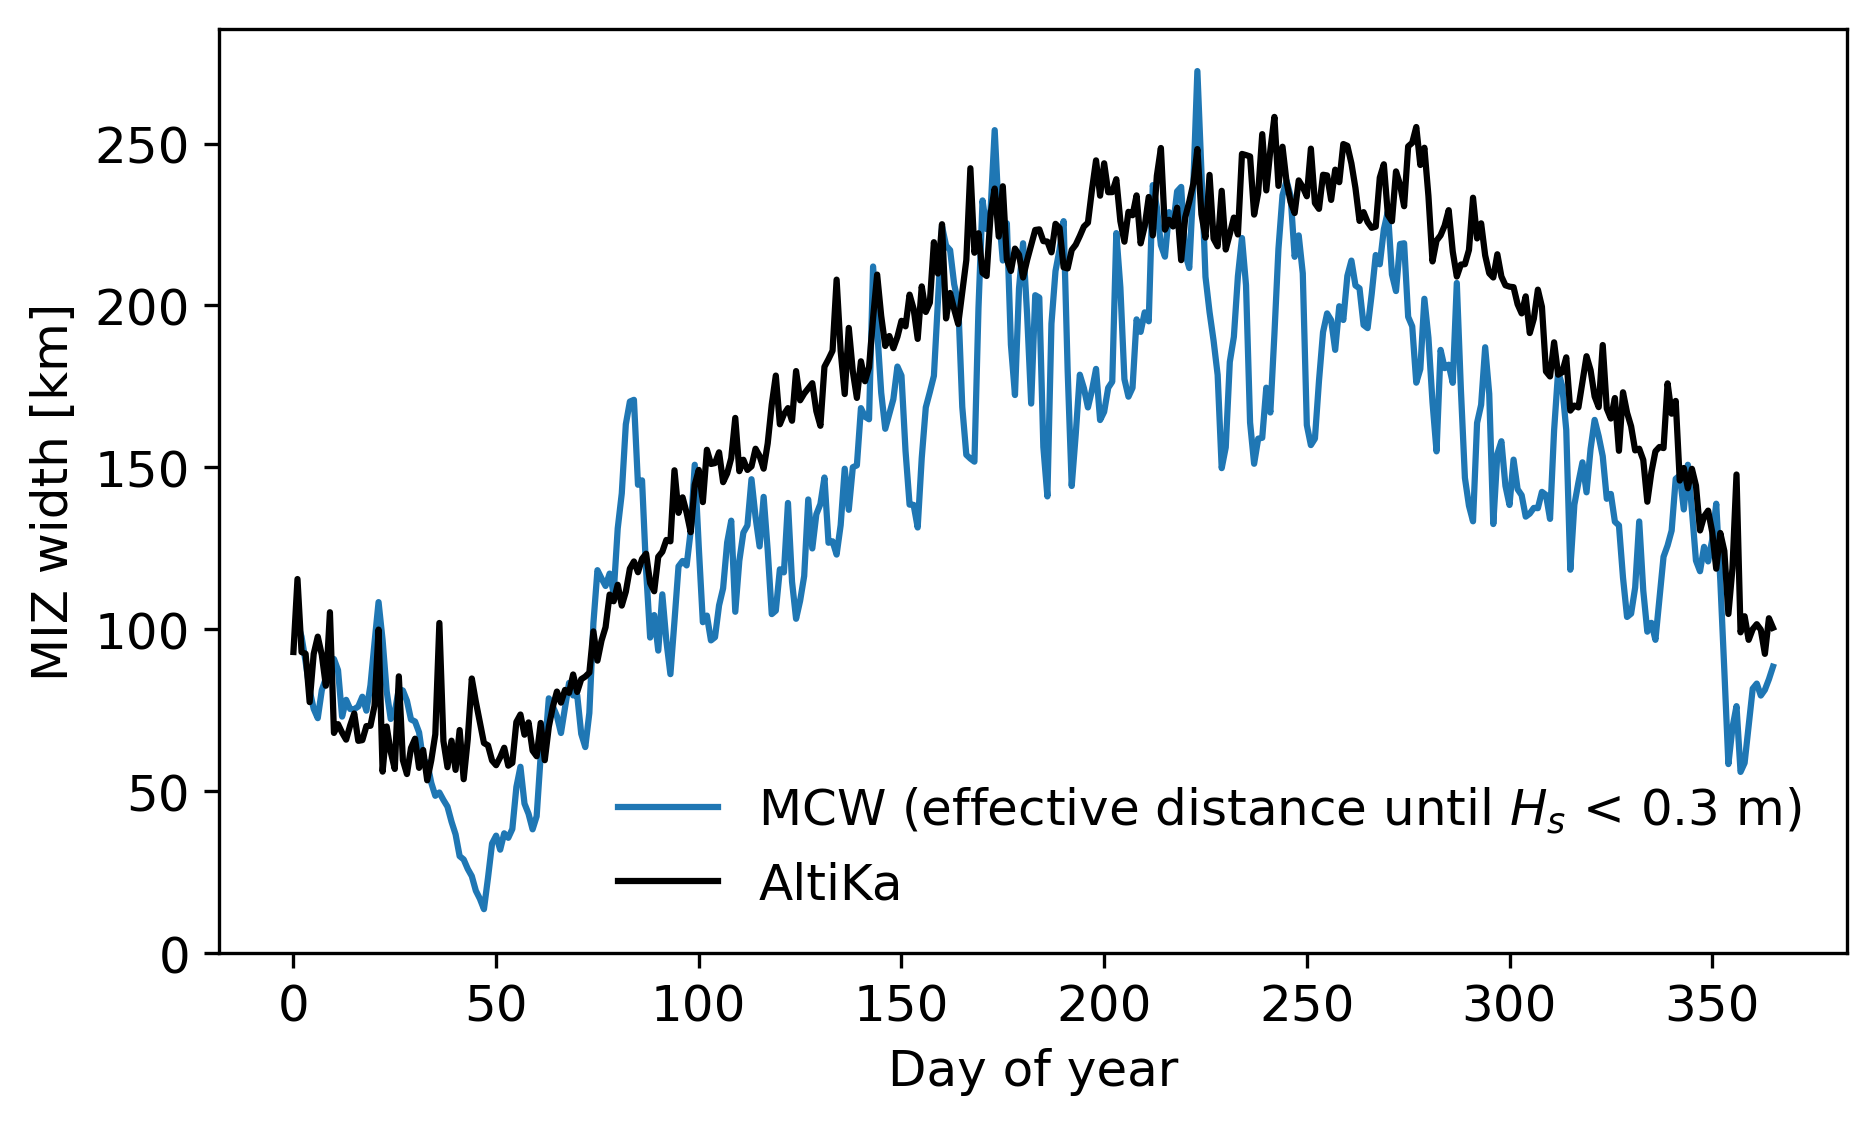

In [32]:
# region = 'ANTARCTICA'
fig, axes = plt.subplots(ncols=1, figsize=(7,4), sharex=True, sharey=True)
ax = axes
x = ds_doy.dayofyear
# ax.plot(x, antarctic_miz_width_wave_d, label='$H_s$ > 0.3 m')
ax.plot(x, antarctic_miz_width_wave_d_eff, label='MCW (effective distance until $H_s$ < 0.3 m)')
# axes[0].plot(x, antarctic_miz_width_aice_d, label='Ice concentration', color='lightblue')
# axes[0].plot(x, antarctic_miz_width_fsdrad_d, label='Floe size')
ax.plot(range(366), df_doy['mizWidthAlongTrackFromMyEdge'], color='k', label="AltiKa")

ax.legend(frameon=False, ncols=1, fontsize=12)
ax.set_ylim(bottom=0)
ax.set_xlabel("Day of year")
ax.set_ylabel("MIZ width [km]")

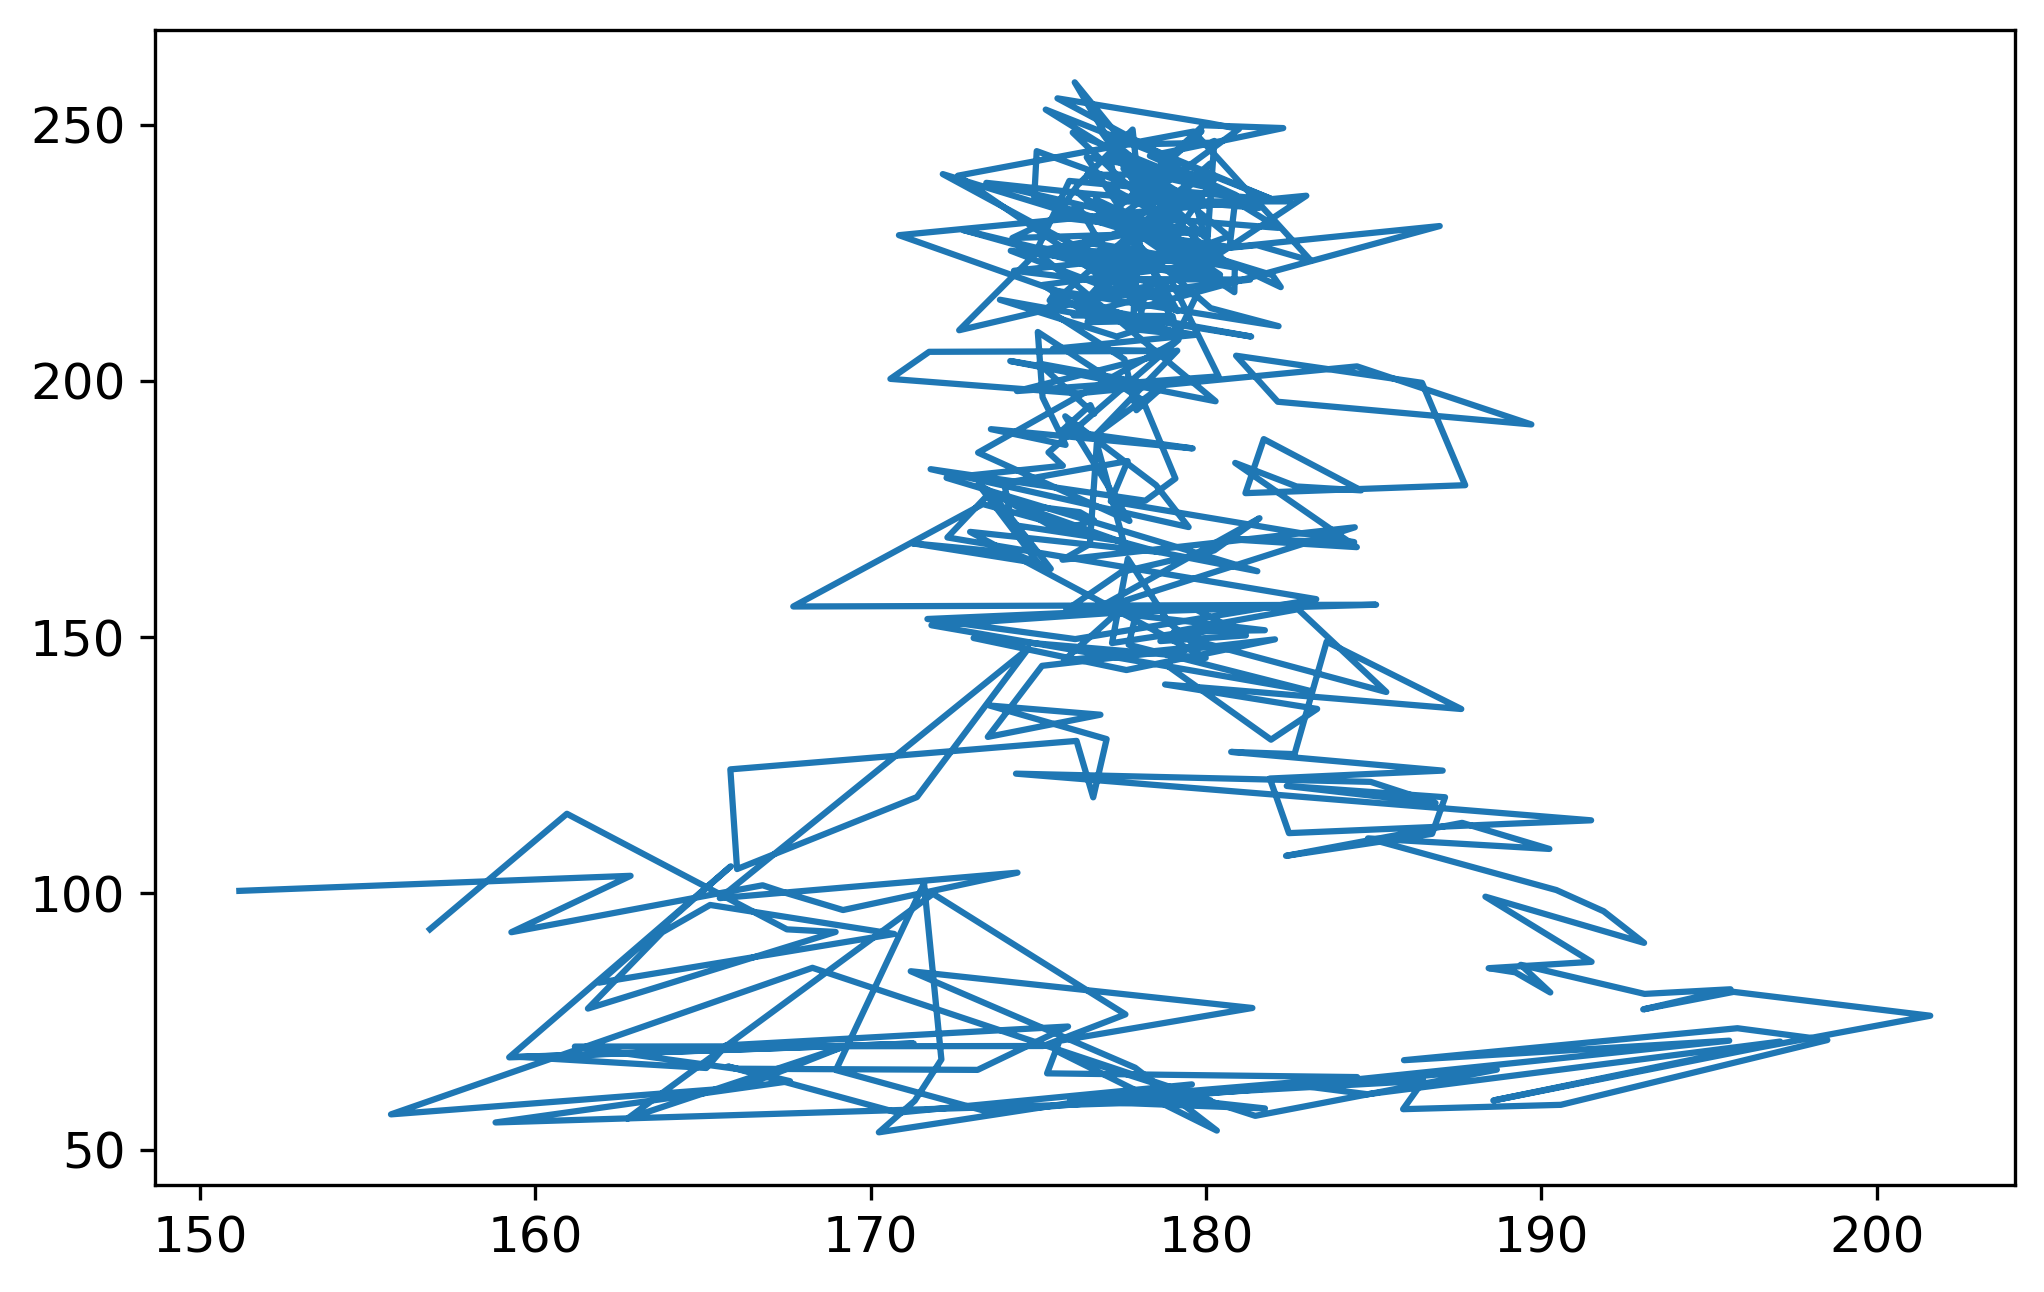

In [33]:
plt.figure(figsize=(8, 5))

plt.plot(df_doy['lonAtMyEdge'], df_doy['mizWidthAlongTrackFromMyEdge'])

In [85]:
# df_all['doy'] = pd.to_datetime(df_all['date']).dt.dayofyear
# df_doy = df_all.groupby('doy').mean(numeric_only=True)

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter(
    df_all['lonAtMyEdge'],
    df_all['doy'],
    c=df_all['mizWidthAlongTrackFromMyEdge'],
    s=20
)
plt.colorbar(label='MIZ Width (km)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('MIZ Width Along Track')
plt.show()

In [ ]:
X, Y = np.meshgrid(df_all['lonAtMyEdge'], df_all['doy'])
Z = df_all['mizWidthAlongTrackFromMyEdge']

plt.pcolormesh(X, Y, Z, shading='auto')
plt.colorbar()

In [42]:
client.close()

2025-12-03 16:15:33,452 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2025-12-03 16:15:33,453 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2025-12-03 16:15:33,454 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2025-12-03 16:15:33,459 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2025-12-03 16:15:33,459 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2025-12-03 16:15:33,460 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2025-12-03 16:15:33,468 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
